<a href="https://colab.research.google.com/github/Aleptonic/VIT-From-Scratch/blob/main/vit_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a ViT on CIFAR-10
Training a Vision Transformer from scratch on a small dataset like CIFAR-10 is a known challenge. The original ViT paper demonstrated that these models require massive datasets to outperform CNNs. This project's core challenge was to overcome this limitation by building a robust pipeline that incorporates a suite of modern, data-efficient training techniques.

The following sections detail the step-by-step implementation, highlighting the key decisions and optimizations made at each stage.
Table of contents
1. Dependencies
2. Configurations
3. Model
4. DataLoader
5. Evaluator
6. Training
7. Experiments
8. Evaluate Best Trained ViT Model

# Dependencies

In [ ]:
import random
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.nn import Softmax, GELU
from dataclasses import dataclass
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import collections
from torchvision.transforms.v2 import MixUp, CutMix

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

from einops import rearrange, repeat
from tqdm import tqdm
import pandas as pd


In [ ]:
# --- to save the model without losing it. ---
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configurations

In [ ]:
@dataclass
class ImageParams:
    width: int
    height: int
    in_channel: int
@dataclass
class ModelParameters:
    patch_size: int
    inner_dim: int
    transformer_layers: int
    num_head: int
    embed_dropout: float
    attn_dropout: float
    mlp_dropout: float
@dataclass
class Hyperparameters:
    batch_size: int
    out_classes: int
    epochs: int
    learning_rate: float
    weight_decay: float


# Model
* **Core Components:** The architecture is broken down into logical `nn.Module` classes: `PatchEmbedding`, `MultiHeadAttention`, `MLP`, and `TransformerEncoderBlock`.

* **Efficient Patching:** Instead of manually slicing and embedding image patches, a more efficient method was used: a single `nn.Conv2d` layer. With a `kernel_size` and `stride` equal to the `patch_size`, this layer performs both the *non-overlapped* patching and the linear projection into the embedding dimension in one highly optimized operation.

* **Stable Architecture (Pre-Norm):** While the original Transformer used a "Post-Norm" structure (LayerNorm *after* the residual connection), we have adopted the more stable **"Pre-Norm"** configuration. Applying `LayerNorm` *before* the Multi-Head Attention and MLP blocks leads to smoother gradients and more stable training.

* **Model Sizing:** Recognizing the risk of overfitting on CIFAR-10, a smaller model variant was chosen. The architecture follows the **DeiT-Ti (Tiny)** specification (`dim=192`, `depth=12`, `heads=3`), providing a better capacity-to-data ratio.


In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, mparams, hparams, img_info):
        super(PatchEmbedding, self).__init__()
        self.patch_size = mparams.patch_size
        self.img_size = img_info.width
        self.num_patches = (self.img_size//self.patch_size) * (self.img_size//self.patch_size)
        self.D = mparams.inner_dim
        self.patch_embed = nn.Conv2d(
            in_channels=img_info.in_channel,
            out_channels=self.D,
            kernel_size=self.patch_size,
            stride=self.patch_size
        )
        self.cls_token = nn.Parameter(torch.rand(1,1,self.D))

    def forward(self, x):
        # Input: [B, C, H, W]
        # Output: [B, N, D] here N is selected num_patches(from image) + 1 (cls token)
        b = x.shape[0]
        cls_token = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = self.patch_embed(x)
        x = rearrange(x, 'b d h w -> b (h w) d')
        x = torch.cat((cls_token, x), dim=1)
        return x
class MHA(nn.Module):
    def __init__(self, mparams, hparams):
        super(MHA, self).__init__()
        self.D = mparams.inner_dim
        self.num_head = mparams.num_head
        assert self.D % self.num_head == 0 , 'Inner dimensions and number of attention head need to be perfectly divisible'
        self.head_size = self.D // self.num_head
        self.all_head_size = self.head_size * self.num_head
        # Set up QKV
        self.query = nn.Linear(in_features=self.D, out_features=self.all_head_size)
        self.key = nn.Linear(in_features=self.D, out_features=self.all_head_size)
        self.value = nn.Linear(in_features=self.D, out_features=self.all_head_size)
        self.output = nn.Linear(in_features=self.D, out_features=self.D)
        self.attn_dropout = nn.Dropout(mparams.attn_dropout)
        self.proj_dropout = nn.Dropout(mparams.attn_dropout)
        self.softmax = Softmax(dim=-1)
    def forward(self, x, mask= None):
        # Input: [B, N, D]
        # For atten: [B, num_head, num_patches, head_size]
        # Output: [B, N, D]
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        # For atten: [B, num_head, num_patches, head_size]
        q = rearrange(q, 'b n (h d) -> b h n d', h=self.num_head)
        k = rearrange(k, 'b n (h d) -> b h n d', h=self.num_head)
        v = rearrange(v, 'b n (h d) -> b h n d', h=self.num_head)
        attn_score = torch.matmul(q, k.transpose(-1, -2))/ self.head_size**0.5
        if mask is not None:
            attn_score = attn_score.masked_fill(mask == 0, -1e9)
        attn_probs = self.softmax(attn_score)
        attn_probs = self.attn_dropout(attn_probs)
         # sum with V
        context = torch.matmul(attn_probs,v) #[B,h,n,d]
        # combine all heads
        context = rearrange(context, 'b h n d -> b n (h d) ')
        output = self.output(context)
        output = self.proj_dropout(output)
        return output
class MLP(nn.Module):
    def __init__(self, mparams, hparams):
        super().__init__()
        self.D = mparams.inner_dim
        self.hidden_dim = 4* self.D
        self.net = nn.Sequential(
            nn.Linear(self.D, self.hidden_dim),
            nn.GELU(),
            nn.Dropout(mparams.mlp_dropout),
            nn.Linear(self.hidden_dim, self.D),
            nn.Dropout(mparams.mlp_dropout)
        )
    def forward(self, x):
        return self.net(x)
class EncoderBlock(nn.Module):
    def __init__(self, mparams, hparams):
        super().__init__()
        self.norm1 = nn.LayerNorm(mparams.inner_dim)
        self.attn = MHA(mparams=mparams, hparams=hparams)
        self.norm2 = nn.LayerNorm(mparams.inner_dim)
        self.ffn = MLP(mparams=mparams, hparams=hparams)
    def forward(self, x):
        residual = x
        x = self.norm1(x)
        x = self.attn(x) + residual

        residual = x
        x = self.norm2(x)
        x = self.ffn(x) + residual
        return x
class Transformer(nn.Module):
    def __init__(self, mparams, hparams):
        super().__init__()
        self.depth = mparams.transformer_layers
        self.layers = nn.ModuleList([
            EncoderBlock(mparams=mparams, hparams=hparams) for _ in range(self.depth)
        ])
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
class ViT(nn.Module):
    def __init__(self, mparams, hparams, img_info):
        super().__init__()
        image_width = img_info.width
        patch_size = mparams.patch_size
        num_patches = (image_width//patch_size)**2
        self.pos_embed = nn.Parameter(torch.rand(1, num_patches+1, mparams.inner_dim))
        self.patch_embed = PatchEmbedding(mparams=mparams, hparams=hparams, img_info=img_info)
        self.transformer = Transformer(mparams=mparams, hparams=hparams)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(mparams.inner_dim),
            nn.Linear(mparams.inner_dim, hparams.out_classes)
        )
        self.embed_dropout = nn.Dropout(mparams.embed_dropout)
    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.embed_dropout(x)
        x = self.transformer(x)
        cls_token_ouput = x[:,0] # or u can do x.mean(dim=1) if we do a mean pooling for the final cls token
        return self.mlp_head(cls_token_ouput)


# DataLoader
* **Initial Approach:** A standard data loader with basic transformations (`ToTensor`, `Normalize`).
* **Key Improvement:** To make the model generalize better, a sophisticated augmentation strategy inspired by the DeiT paper was implemented.
    * **In-Transform Augmentations:** `RandomHorizontalFlip` and `RandomResizedCrop` were added to provide basic geometric variance.
    * **Batch-Level Augmentations:** Standard transforms are applied per-image. To further regularize the model, **`Mixup` and `CutMix`** are used.

In [ ]:
# for cutmix, mixup
if not hasattr(collections.abc, 'Sequence'):
    collections.abc.Sequence = collections.Sequence

class DataHandler:
    def __init__(self, image_information, batch_size):
        self.img_info = image_information
        self.batch_size = batch_size

    def _train_transform(self):
        return transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomResizedCrop((self.img_info.width, self.img_info.height), scale=(0.8, 1.0)),
            # num_ops = number of augmentations to apply
            # magnitude = strength of augmentations
            transforms.RandAugment(num_ops=2, magnitude=9), # can be tweaked after checking how similar the images are
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])

    def _val_test_transform(self):
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])

    def get_dataloaders(self):
        train_dataset = datasets.CIFAR10(root='./data', train=True,
                                         download=True, transform=self._train_transform())

        val_dataset = datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=self._val_test_transform())

        # crave validation from train
        num_train = len(train_dataset)
        indices = list(range(num_train))

        torch.utils.data.sampler.SubsetRandomSampler(indices)
        split = int(0.9 * num_train)
        train_indices, val_indices = indices[:split], indices[split:]

        # Create subsets based on the indices
        train_subset = Subset(train_dataset, train_indices)
        val_subset = Subset(val_dataset, val_indices)


        test_dataset = datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=self._val_test_transform())

        # cutmix and mixup need to be used directly on batch, not working with transforms (ofc)
        mixup_cutmix = [
            MixUp(alpha=1.0, num_classes=10),
            CutMix(alpha=1.0, num_classes=10)
        ]
        combine_fn = lambda batch: mixup_cutmix[torch.randint(0,2,(1,)).item()](*torch.utils.data.default_collate(batch))


        # dataloaders
        train_loader = DataLoader(train_subset, batch_size=self.batch_size,
                                  shuffle=True, num_workers=2, collate_fn=combine_fn)

        val_loader = DataLoader(val_subset, batch_size=self.batch_size,
                                shuffle=False, num_workers=2)

        test_loader = DataLoader(test_dataset, batch_size=self.batch_size,
                                 shuffle=False, num_workers=2)

        print("DataLoaders created successfully.")
        print(f"Training samples: {len(train_subset)}")
        print(f"Validation samples: {len(val_subset)}")
        print(f"Test samples: {len(test_dataset)}")

        return train_loader, val_loader, test_loader

# Evaluator

In [ ]:
class Evaluator:
    def __init__(self, model, test_loader, device, output_dir):
        self.model = model
        self.test_loader = test_loader
        self.device = device
        self.output_dir = output_dir
        # Get class names from the dataset object
        self.class_names = self.test_loader.dataset.dataset.classes if isinstance(self.test_loader.dataset, Subset) else self.test_loader.dataset.classes

    def plot_confusion_matrix(self, cm, file_path):
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.class_names, yticklabels=self.class_names)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.title('Confusion Matrix', fontsize=15)
        plt.savefig(file_path)
        plt.show()

    def evaluate(self, model_path):
        print(f"\n--- Starting Final Evaluation ---")
        # Load model state dictionary with map_location
        self.model.load_state_dict(torch.load(model_path, map_location=torch.device(self.device)))
        #self.model.to(self.device) # check this later if needed or not
        self.model.eval()

        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in tqdm(self.test_loader, desc="Testing"):
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # --- Calculate Metrics ---
        report_dict = classification_report(all_labels, all_preds,
                                            target_names=self.class_names, output_dict=True)
        cm = confusion_matrix(all_labels, all_preds)

        # Calculate class-wise accuracy from the confusion matrix
        class_accuracies = cm.diagonal() / cm.sum(axis=1)
        for i, class_name in enumerate(self.class_names):
            report_dict[class_name]['accuracy'] = class_accuracies[i]

        # Add overall accuracy to the report
        report_dict['overall_accuracy'] = accuracy_score(all_labels, all_preds)

        # --- Save & Display Results ---
        print(f"\nOverall Test Accuracy: {report_dict['overall_accuracy'] * 100:.2f}%")

        # Display results in a clean table using pandas
        report_df = pd.DataFrame(report_dict).transpose()
        print("\nClassification Report:")
        print(report_df.to_string())

        # Save report to JSON
        report_path = os.path.join(self.output_dir, "classification_report.json")
        report_df.to_json(report_path, indent=4)
        print(f"\nFull report saved to {report_path}")

        # Plot and save confusion matrix
        cm_path = os.path.join(self.output_dir, "confusion_matrix.png")
        self.plot_confusion_matrix(cm, cm_path)
        print(f"Confusion matrix plot saved to {cm_path}")

        return report_dict

# Training
* **Optimizer:** The **`AdamW`** optimizer was chosen over vanilla `Adam`. AdamW decouples the weight decay from the gradient updates, providing more effective regularization, which is a standard practice for training Transformers.

* **Learning Rate Scheduling:** A fixed learning rate is suboptimal for complex models. The **`OneCycleLR`** scheduler was implemented. This powerful scheduler automatically manages a two-phase cycle:
    1.  A **warmup phase**, where the learning rate gradually increases. This prevents large, destabilizing updates at the start.

    2.  An **annealing phase (cosine anealing)**, where the learning rate smoothly decays. This allows the model to settle into a deep and stable minimum in the loss landscape.



In [ ]:
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import random
import numpy as np
class Trainer:
    def __init__(self, model, train_loader, val_loader, optimizer, scaler, lr_scheduler, epochs):
        self.device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.mps.is_available() else 'cpu')
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = nn.CrossEntropyLoss()
        self.optim = optimizer
        self.scaler = scaler
        self.lr_sch = lr_scheduler
        self.epochs = epochs
    def _train_one_epoch(self):
        model = self.model
        model.train()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0
        for image, label in tqdm(self.train_loader, desc='Training'):
            img, label = image.to(self.device), label.to(self.device)
            # Trying automatic mixed precision (AMP)
            if self.device =='cuda':
                with torch.amp.autocast(device_type=self.device):
                    logits = model(img)
                    loss = self.criterion(logits, label)
            # Backpropagation
            self.optim.zero_grad()
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optim)
            self.scaler.update()
            # Update lr
            self.lr_sch.step()
            # Metrics
            total_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            # Check if labels are one-hot/soft (multi-dimensional) or hard integers (1D)
            if label.dim() > 1: # This means it's one-hot or soft labels from Mixup/CutMix
                _, true_labels = torch.max(label, 1) # Convert soft labels back to hard labels
            else: # This means it's hard integer labels
                true_labels = label # Labels are already the class IDs
            total_samples += label.size(0)
            total_correct += (predicted == true_labels).sum().item()

        avg_loss = total_loss / len(self.train_loader)
        accuracy = 100 * total_correct / total_samples
        return avg_loss, accuracy
    def _validate(self):
        model = self.model
        model.eval()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        with torch.no_grad():
            for images, labels in tqdm(self.val_loader, desc="Validating"):
                images, labels = images.to(self.device), labels.to(self.device)

                # Note: No need for AMP here, but it's fine if used
                outputs = model(images)
                loss = self.criterion(outputs, labels)

                # Metrics
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_samples += labels.size(0)
                total_correct += (predicted == labels).sum().item()

        avg_loss = total_loss / len(self.val_loader)
        accuracy = 100 * total_correct / total_samples
        return avg_loss, accuracy
    def _run_trainer(self, model_path):
        model = self.model
        model.to(self.device)
        best_val_accuracy = 0.0
        history = []
        print("Starting Training...")
        for epoch in range(self.epochs):
            print(f"--- Epoch {epoch+1}/{self.epochs} ---")

            train_loss, train_acc = self._train_one_epoch()
            val_loss, val_acc = self._validate()

            print(f"Epoch {epoch+1} Summary:")
            print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
            print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
            print(f"  Current Learning Rate: {self.optim.param_groups[0]['lr']:.6f}")


            history.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'lr': f"{self.optim.param_groups[0]['lr']:.6f}"
            })

            # Save the model if it has the best validation accuracy so far
            if val_acc > best_val_accuracy:
                best_val_accuracy = val_acc
                torch.save(model.state_dict(), model_path)
                print(f"✅ New best model saved with accuracy: {best_val_accuracy:.2f}%")

        print("--- Training Finished ---")
        print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")
        return history
    @staticmethod
    def set_seed(seed: int):
      """
      Sets the seed for reproducibility. We will avoid the strictest settings
      to prevent runtime errors on the GPU.
      """
      random.seed(seed)
      np.random.seed(seed)
      torch.manual_seed(seed)

      if torch.cuda.is_available():
          torch.cuda.manual_seed(seed)
          torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.

      torch.backends.cudnn.deterministic = False
      torch.backends.cudnn.benchmark = True # Set to True for speed

In [ ]:
def main(num_runs, master_seed, test_name, image_information, model_parameters, hyperparameters):
    NUM_RUNS = num_runs
    """ Checking MASTER_SEED
    1. MASTER_SEED = 42  --> used for trial runs (T0)
    2. MASTER_SEED = 100 --> used for base testing (F0)
    """
    MASTER_SEED = master_seed
    for i in range(NUM_RUNS):
        run_seed = i+MASTER_SEED
        Trainer.set_seed(seed=run_seed)
        print(f"\n--- Starting Run {i+1}/{NUM_RUNS} (Seed: {run_seed}) ---")

        run_name = test_name+ f'_{i+1}'
        #run_output_dir = f"run_outputs/{run_name}"
        run_output_dir = f"/content/drive/MyDrive/IISc_Submission/{run_name}" # SAVING TO DRIVE
        local_model_path = os.path.join(run_output_dir, "best_model.pth")
        eval_results_dir = os.path.join(run_output_dir, "evaluation_results")
        history_path = os.path.join(run_output_dir, "training_history.csv")
        os.makedirs(run_output_dir, exist_ok=True)
        os.makedirs(eval_results_dir, exist_ok=True)

        img_info = image_information
        mparams = model_parameters
        hparams = hyperparameters

        data_handler = DataHandler(image_information=img_info, batch_size=hparams.batch_size)
        train_loader, val_loader, test_loader = data_handler.get_dataloaders()

        base_model = ViT(mparams=mparams, hparams=hparams, img_info=img_info)
        base_optimizer = optim.AdamW(params=base_model.parameters(), lr=hparams.learning_rate, weight_decay=hparams.weight_decay)
        base_scaler = torch.amp.GradScaler(device='cuda')
        base_scheduler = OneCycleLR(optimizer=base_optimizer, max_lr=hparams.learning_rate, steps_per_epoch=len(train_loader), epochs=hparams.epochs)

        trainer = Trainer(model=base_model, train_loader=train_loader, val_loader=val_loader, optimizer=base_optimizer, scaler=base_scaler, lr_scheduler=base_scheduler, epochs=hparams.epochs)
        training_history = trainer._run_trainer(model_path=local_model_path)
        history_df = pd.DataFrame(training_history)
        history_df.to_csv(history_path, index=False)
        print(f"Training history saved to {history_path}")
        print("\n--- Training complete. Starting final evaluation on test set. ---")
        evaluator = Evaluator(
        model=base_model,
        test_loader=test_loader,
        device=trainer.device,
        output_dir=eval_results_dir)
        final_metrics = evaluator.evaluate(model_path=local_model_path)




# Experiments

In [ ]:
# -- checking dimension error __
test_tensor = torch.rand(2,3,32,32)
print(f'test tensor shape: {test_tensor.shape}')
vit = ViT(mparams=ModelParameters(patch_size=4, inner_dim=192, transformer_layers=12, num_head=3, embed_dropout=0.1, attn_dropout=0.0, mlp_dropout=0.1), hparams=Hyperparameters(batch_size=1024, out_classes=10, epochs=10, learning_rate=5e-4*(1024/512), weight_decay=0.05), img_info=ImageParams(width=32, height=32, in_channel=3))
output = vit.forward(test_tensor)
print(f'Output Shape: {output.shape}')

test tensor shape: torch.Size([2, 3, 32, 32])
Output Shape: torch.Size([2, 10])



--- Starting Run 1/1 (Seed: 100) ---
DataLoaders created successfully.
Training samples: 45000
Validation samples: 5000
Test samples: 10000

--- Training complete. Starting final evaluation on test set. ---

--- Starting Final Evaluation ---


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]



Overall Test Accuracy: 79.29%

Classification Report:
                  precision  recall  f1-score     support  accuracy
airplane           0.727425  0.8700  0.792350   1000.0000    0.8700
automobile         0.883284  0.8930  0.888115   1000.0000    0.8930
bird               0.775306  0.6970  0.734071   1000.0000    0.6970
cat                0.712468  0.5600  0.627100   1000.0000    0.5600
deer               0.799542  0.6980  0.745328   1000.0000    0.6980
dog                0.720120  0.7230  0.721557   1000.0000    0.7230
frog               0.777193  0.8860  0.828037   1000.0000    0.8860
horse              0.787659  0.8680  0.825880   1000.0000    0.8680
ship               0.895984  0.8700  0.882801   1000.0000    0.8700
truck              0.848723  0.8640  0.856293   1000.0000    0.8640
accuracy           0.792900  0.7929  0.792900      0.7929    0.7929
macro avg          0.792770  0.7929  0.790153  10000.0000       NaN
weighted avg       0.792770  0.7929  0.790153  10000.0000    

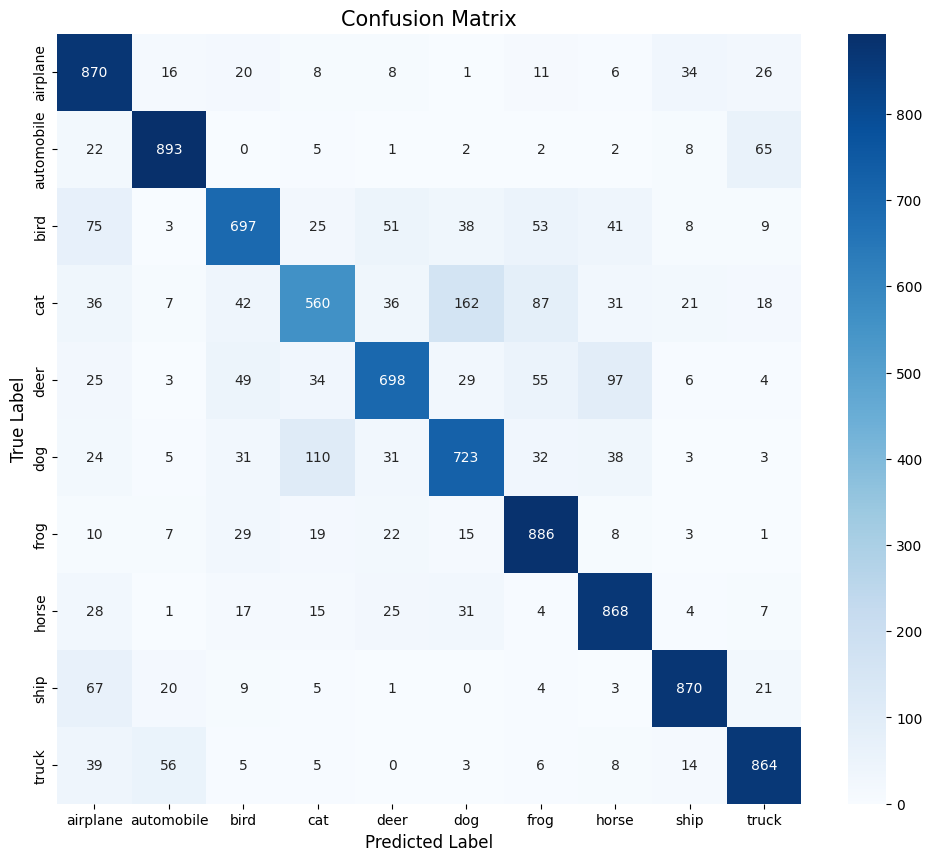

Confusion matrix plot saved to /content/drive/MyDrive/IISc_Submission/base_testing_F0_1/evaluation_results/confusion_matrix.png


In [ ]:
# --- base testing ---
main(
    num_runs=1,
    master_seed=100,
    test_name=f'base_testing_F0',
    image_information=ImageParams(width=32, height=32, in_channel=3),
    model_parameters=ModelParameters(patch_size=4, inner_dim=192, transformer_layers=12, num_head=3, embed_dropout=0.1, attn_dropout=0.0, mlp_dropout=0.1),
    hyperparameters=Hyperparameters(batch_size=1024, out_classes=10, epochs=100, learning_rate=5e-4*(1024/512), weight_decay=0.05)
)

In [ ]:
# --- trying to run for 300 epochs like DeiT paper
main(
    num_runs=1,
    master_seed=200,
    test_name=f'deit_trial_F1',
    image_information=ImageParams(width=32, height=32, in_channel=3),
    model_parameters=ModelParameters(patch_size=4, inner_dim=192, transformer_layers=12, num_head=3, embed_dropout=0.1, attn_dropout=0.0, mlp_dropout=0.1),
    hyperparameters=Hyperparameters(batch_size=1024, out_classes=10, epochs=300, learning_rate=5e-4*(1024/512), weight_decay=0.05)
)



--- Starting Run 1/1 (Seed: 200) ---
DataLoaders created successfully.
Training samples: 45000
Validation samples: 5000
Test samples: 10000
Starting Training...
--- Epoch 1/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


Epoch 1 Summary:
  Train Loss: 2.2618 | Train Acc: 15.43%
  Val Loss:   2.0639 | Val Acc:   22.18%
  Current Learning Rate: 0.000040
✅ New best model saved with accuracy: 22.18%
--- Epoch 2/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Epoch 2 Summary:
  Train Loss: 2.2046 | Train Acc: 18.23%
  Val Loss:   2.0113 | Val Acc:   25.84%
  Current Learning Rate: 0.000041
✅ New best model saved with accuracy: 25.84%
--- Epoch 3/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 3 Summary:
  Train Loss: 2.1813 | Train Acc: 19.92%
  Val Loss:   1.9828 | Val Acc:   27.16%
  Current Learning Rate: 0.000043
✅ New best model saved with accuracy: 27.16%
--- Epoch 4/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Epoch 4 Summary:
  Train Loss: 2.1649 | Train Acc: 20.98%
  Val Loss:   1.9550 | Val Acc:   28.00%
  Current Learning Rate: 0.000045
✅ New best model saved with accuracy: 28.00%
--- Epoch 5/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 5 Summary:
  Train Loss: 2.1651 | Train Acc: 20.82%
  Val Loss:   1.9334 | Val Acc:   27.94%
  Current Learning Rate: 0.000047
--- Epoch 6/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 6 Summary:
  Train Loss: 2.1441 | Train Acc: 22.54%
  Val Loss:   1.8741 | Val Acc:   32.30%
  Current Learning Rate: 0.000050
✅ New best model saved with accuracy: 32.30%
--- Epoch 7/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Epoch 7 Summary:
  Train Loss: 2.1353 | Train Acc: 22.84%
  Val Loss:   1.8361 | Val Acc:   34.10%
  Current Learning Rate: 0.000054
✅ New best model saved with accuracy: 34.10%
--- Epoch 8/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 8 Summary:
  Train Loss: 2.1397 | Train Acc: 22.87%
  Val Loss:   1.8048 | Val Acc:   35.06%
  Current Learning Rate: 0.000059
✅ New best model saved with accuracy: 35.06%
--- Epoch 9/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 9 Summary:
  Train Loss: 2.1173 | Train Acc: 23.76%
  Val Loss:   1.7984 | Val Acc:   35.40%
  Current Learning Rate: 0.000064
✅ New best model saved with accuracy: 35.40%
--- Epoch 10/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 10 Summary:
  Train Loss: 2.1183 | Train Acc: 24.16%
  Val Loss:   1.7811 | Val Acc:   36.48%
  Current Learning Rate: 0.000069
✅ New best model saved with accuracy: 36.48%
--- Epoch 11/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 11 Summary:
  Train Loss: 2.0997 | Train Acc: 25.14%
  Val Loss:   1.7385 | Val Acc:   37.96%
  Current Learning Rate: 0.000075
✅ New best model saved with accuracy: 37.96%
--- Epoch 12/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 12 Summary:
  Train Loss: 2.0469 | Train Acc: 27.57%
  Val Loss:   1.6963 | Val Acc:   38.64%
  Current Learning Rate: 0.000082
✅ New best model saved with accuracy: 38.64%
--- Epoch 13/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 13 Summary:
  Train Loss: 2.0192 | Train Acc: 29.40%
  Val Loss:   1.6364 | Val Acc:   41.50%
  Current Learning Rate: 0.000089
✅ New best model saved with accuracy: 41.50%
--- Epoch 14/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 14 Summary:
  Train Loss: 2.0614 | Train Acc: 27.73%
  Val Loss:   1.6251 | Val Acc:   41.40%
  Current Learning Rate: 0.000096
--- Epoch 15/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 15 Summary:
  Train Loss: 2.0187 | Train Acc: 30.35%
  Val Loss:   1.5941 | Val Acc:   42.82%
  Current Learning Rate: 0.000104
✅ New best model saved with accuracy: 42.82%
--- Epoch 16/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 16 Summary:
  Train Loss: 2.0177 | Train Acc: 30.80%
  Val Loss:   1.5194 | Val Acc:   45.80%
  Current Learning Rate: 0.000113
✅ New best model saved with accuracy: 45.80%
--- Epoch 17/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 17 Summary:
  Train Loss: 1.9646 | Train Acc: 32.66%
  Val Loss:   1.5059 | Val Acc:   46.32%
  Current Learning Rate: 0.000122
✅ New best model saved with accuracy: 46.32%
--- Epoch 18/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 18 Summary:
  Train Loss: 1.9902 | Train Acc: 31.60%
  Val Loss:   1.5393 | Val Acc:   44.80%
  Current Learning Rate: 0.000132
--- Epoch 19/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 19 Summary:
  Train Loss: 1.9563 | Train Acc: 33.34%
  Val Loss:   1.5273 | Val Acc:   44.68%
  Current Learning Rate: 0.000142
--- Epoch 20/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 20 Summary:
  Train Loss: 1.9840 | Train Acc: 32.74%
  Val Loss:   1.4664 | Val Acc:   47.68%
  Current Learning Rate: 0.000152
✅ New best model saved with accuracy: 47.68%
--- Epoch 21/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 21 Summary:
  Train Loss: 1.9756 | Train Acc: 33.32%
  Val Loss:   1.4542 | Val Acc:   48.78%
  Current Learning Rate: 0.000163
✅ New best model saved with accuracy: 48.78%
--- Epoch 22/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 22 Summary:
  Train Loss: 1.9822 | Train Acc: 32.61%
  Val Loss:   1.4401 | Val Acc:   48.22%
  Current Learning Rate: 0.000175
--- Epoch 23/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 23 Summary:
  Train Loss: 1.9620 | Train Acc: 33.46%
  Val Loss:   1.4225 | Val Acc:   50.38%
  Current Learning Rate: 0.000187
✅ New best model saved with accuracy: 50.38%
--- Epoch 24/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 24 Summary:
  Train Loss: 1.9289 | Train Acc: 35.34%
  Val Loss:   1.3851 | Val Acc:   50.78%
  Current Learning Rate: 0.000199
✅ New best model saved with accuracy: 50.78%
--- Epoch 25/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 25 Summary:
  Train Loss: 1.9342 | Train Acc: 35.53%
  Val Loss:   1.3506 | Val Acc:   51.46%
  Current Learning Rate: 0.000212
✅ New best model saved with accuracy: 51.46%
--- Epoch 26/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 26 Summary:
  Train Loss: 1.9117 | Train Acc: 36.41%
  Val Loss:   1.3480 | Val Acc:   53.52%
  Current Learning Rate: 0.000225
✅ New best model saved with accuracy: 53.52%
--- Epoch 27/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


Epoch 27 Summary:
  Train Loss: 1.9044 | Train Acc: 37.57%
  Val Loss:   1.3584 | Val Acc:   54.22%
  Current Learning Rate: 0.000238
✅ New best model saved with accuracy: 54.22%
--- Epoch 28/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 28 Summary:
  Train Loss: 1.8952 | Train Acc: 37.17%
  Val Loss:   1.4233 | Val Acc:   52.08%
  Current Learning Rate: 0.000252
--- Epoch 29/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 29 Summary:
  Train Loss: 1.9295 | Train Acc: 35.62%
  Val Loss:   1.3290 | Val Acc:   54.94%
  Current Learning Rate: 0.000266
✅ New best model saved with accuracy: 54.94%
--- Epoch 30/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 30 Summary:
  Train Loss: 1.8348 | Train Acc: 40.03%
  Val Loss:   1.3385 | Val Acc:   54.60%
  Current Learning Rate: 0.000280
--- Epoch 31/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 31 Summary:
  Train Loss: 1.9337 | Train Acc: 35.74%
  Val Loss:   1.3062 | Val Acc:   55.40%
  Current Learning Rate: 0.000295
✅ New best model saved with accuracy: 55.40%
--- Epoch 32/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 32 Summary:
  Train Loss: 1.8892 | Train Acc: 38.40%
  Val Loss:   1.2644 | Val Acc:   57.10%
  Current Learning Rate: 0.000310
✅ New best model saved with accuracy: 57.10%
--- Epoch 33/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 33 Summary:
  Train Loss: 1.8602 | Train Acc: 39.70%
  Val Loss:   1.2610 | Val Acc:   57.16%
  Current Learning Rate: 0.000325
✅ New best model saved with accuracy: 57.16%
--- Epoch 34/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 34 Summary:
  Train Loss: 1.8186 | Train Acc: 40.91%
  Val Loss:   1.2276 | Val Acc:   57.64%
  Current Learning Rate: 0.000340
✅ New best model saved with accuracy: 57.64%
--- Epoch 35/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 35 Summary:
  Train Loss: 1.9069 | Train Acc: 38.12%
  Val Loss:   1.2450 | Val Acc:   58.98%
  Current Learning Rate: 0.000356
✅ New best model saved with accuracy: 58.98%
--- Epoch 36/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 36 Summary:
  Train Loss: 1.8769 | Train Acc: 39.28%
  Val Loss:   1.2612 | Val Acc:   57.92%
  Current Learning Rate: 0.000372
--- Epoch 37/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 37 Summary:
  Train Loss: 1.8406 | Train Acc: 41.12%
  Val Loss:   1.1942 | Val Acc:   60.36%
  Current Learning Rate: 0.000388
✅ New best model saved with accuracy: 60.36%
--- Epoch 38/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 38 Summary:
  Train Loss: 1.7909 | Train Acc: 42.52%
  Val Loss:   1.2464 | Val Acc:   58.00%
  Current Learning Rate: 0.000404
--- Epoch 39/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 39 Summary:
  Train Loss: 1.8469 | Train Acc: 41.26%
  Val Loss:   1.1943 | Val Acc:   60.32%
  Current Learning Rate: 0.000420
--- Epoch 40/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 40 Summary:
  Train Loss: 1.8547 | Train Acc: 39.83%
  Val Loss:   1.2152 | Val Acc:   59.76%
  Current Learning Rate: 0.000437
--- Epoch 41/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 41 Summary:
  Train Loss: 1.8347 | Train Acc: 41.44%
  Val Loss:   1.1576 | Val Acc:   60.38%
  Current Learning Rate: 0.000453
✅ New best model saved with accuracy: 60.38%
--- Epoch 42/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 42 Summary:
  Train Loss: 1.7668 | Train Acc: 44.44%
  Val Loss:   1.1448 | Val Acc:   62.58%
  Current Learning Rate: 0.000470
✅ New best model saved with accuracy: 62.58%
--- Epoch 43/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 43 Summary:
  Train Loss: 1.8181 | Train Acc: 42.14%
  Val Loss:   1.1828 | Val Acc:   59.46%
  Current Learning Rate: 0.000487
--- Epoch 44/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 44 Summary:
  Train Loss: 1.7543 | Train Acc: 45.39%
  Val Loss:   1.1839 | Val Acc:   60.08%
  Current Learning Rate: 0.000503
--- Epoch 45/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 45 Summary:
  Train Loss: 1.7927 | Train Acc: 43.46%
  Val Loss:   1.1474 | Val Acc:   61.10%
  Current Learning Rate: 0.000520
--- Epoch 46/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 46 Summary:
  Train Loss: 1.8135 | Train Acc: 42.60%
  Val Loss:   1.1942 | Val Acc:   59.20%
  Current Learning Rate: 0.000537
--- Epoch 47/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 47 Summary:
  Train Loss: 1.7754 | Train Acc: 44.10%
  Val Loss:   1.1686 | Val Acc:   61.20%
  Current Learning Rate: 0.000554
--- Epoch 48/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 48 Summary:
  Train Loss: 1.7728 | Train Acc: 44.56%
  Val Loss:   1.0502 | Val Acc:   64.76%
  Current Learning Rate: 0.000570
✅ New best model saved with accuracy: 64.76%
--- Epoch 49/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 49 Summary:
  Train Loss: 1.7544 | Train Acc: 44.93%
  Val Loss:   1.0961 | Val Acc:   63.70%
  Current Learning Rate: 0.000587
--- Epoch 50/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 50 Summary:
  Train Loss: 1.7351 | Train Acc: 46.13%
  Val Loss:   1.0698 | Val Acc:   64.72%
  Current Learning Rate: 0.000604
--- Epoch 51/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 51 Summary:
  Train Loss: 1.7144 | Train Acc: 46.86%
  Val Loss:   1.0710 | Val Acc:   63.50%
  Current Learning Rate: 0.000620
--- Epoch 52/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 52 Summary:
  Train Loss: 1.7493 | Train Acc: 46.88%
  Val Loss:   1.0340 | Val Acc:   66.16%
  Current Learning Rate: 0.000636
✅ New best model saved with accuracy: 66.16%
--- Epoch 53/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 53 Summary:
  Train Loss: 1.7539 | Train Acc: 46.00%
  Val Loss:   1.0682 | Val Acc:   63.68%
  Current Learning Rate: 0.000653
--- Epoch 54/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 54 Summary:
  Train Loss: 1.6700 | Train Acc: 48.27%
  Val Loss:   1.0133 | Val Acc:   65.26%
  Current Learning Rate: 0.000669
--- Epoch 55/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch 55 Summary:
  Train Loss: 1.7663 | Train Acc: 45.75%
  Val Loss:   1.0673 | Val Acc:   64.88%
  Current Learning Rate: 0.000684
--- Epoch 56/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 56 Summary:
  Train Loss: 1.7747 | Train Acc: 45.03%
  Val Loss:   1.0513 | Val Acc:   66.16%
  Current Learning Rate: 0.000700
--- Epoch 57/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 57 Summary:
  Train Loss: 1.7136 | Train Acc: 47.91%
  Val Loss:   1.0122 | Val Acc:   66.48%
  Current Learning Rate: 0.000715
✅ New best model saved with accuracy: 66.48%
--- Epoch 58/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 58 Summary:
  Train Loss: 1.6948 | Train Acc: 48.69%
  Val Loss:   1.1536 | Val Acc:   62.26%
  Current Learning Rate: 0.000731
--- Epoch 59/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 59 Summary:
  Train Loss: 1.7291 | Train Acc: 47.13%
  Val Loss:   0.9783 | Val Acc:   68.86%
  Current Learning Rate: 0.000746
✅ New best model saved with accuracy: 68.86%
--- Epoch 60/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 60 Summary:
  Train Loss: 1.7450 | Train Acc: 47.08%
  Val Loss:   0.9886 | Val Acc:   67.36%
  Current Learning Rate: 0.000760
--- Epoch 61/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch 61 Summary:
  Train Loss: 1.7555 | Train Acc: 45.48%
  Val Loss:   1.0450 | Val Acc:   66.58%
  Current Learning Rate: 0.000775
--- Epoch 62/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 62 Summary:
  Train Loss: 1.6364 | Train Acc: 51.20%
  Val Loss:   0.9214 | Val Acc:   69.80%
  Current Learning Rate: 0.000789
✅ New best model saved with accuracy: 69.80%
--- Epoch 63/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 63 Summary:
  Train Loss: 1.7549 | Train Acc: 46.77%
  Val Loss:   1.0207 | Val Acc:   67.30%
  Current Learning Rate: 0.000802
--- Epoch 64/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 64 Summary:
  Train Loss: 1.6969 | Train Acc: 48.56%
  Val Loss:   1.0256 | Val Acc:   67.66%
  Current Learning Rate: 0.000816
--- Epoch 65/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 65 Summary:
  Train Loss: 1.6821 | Train Acc: 49.70%
  Val Loss:   0.9614 | Val Acc:   68.50%
  Current Learning Rate: 0.000829
--- Epoch 66/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 66 Summary:
  Train Loss: 1.7069 | Train Acc: 48.13%
  Val Loss:   0.9950 | Val Acc:   67.22%
  Current Learning Rate: 0.000841
--- Epoch 67/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 67 Summary:
  Train Loss: 1.6633 | Train Acc: 50.03%
  Val Loss:   1.0054 | Val Acc:   66.76%
  Current Learning Rate: 0.000854
--- Epoch 68/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 68 Summary:
  Train Loss: 1.6796 | Train Acc: 49.75%
  Val Loss:   0.9325 | Val Acc:   69.98%
  Current Learning Rate: 0.000865
✅ New best model saved with accuracy: 69.98%
--- Epoch 69/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 69 Summary:
  Train Loss: 1.7608 | Train Acc: 45.87%
  Val Loss:   0.9529 | Val Acc:   67.52%
  Current Learning Rate: 0.000877
--- Epoch 70/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 70 Summary:
  Train Loss: 1.6387 | Train Acc: 50.57%
  Val Loss:   0.9360 | Val Acc:   69.10%
  Current Learning Rate: 0.000888
--- Epoch 71/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 71 Summary:
  Train Loss: 1.6669 | Train Acc: 50.54%
  Val Loss:   0.8935 | Val Acc:   70.92%
  Current Learning Rate: 0.000898
✅ New best model saved with accuracy: 70.92%
--- Epoch 72/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 72 Summary:
  Train Loss: 1.6370 | Train Acc: 51.38%
  Val Loss:   0.9385 | Val Acc:   67.98%
  Current Learning Rate: 0.000909
--- Epoch 73/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 73 Summary:
  Train Loss: 1.5769 | Train Acc: 53.91%
  Val Loss:   0.9095 | Val Acc:   69.76%
  Current Learning Rate: 0.000918
--- Epoch 74/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 74 Summary:
  Train Loss: 1.6297 | Train Acc: 50.82%
  Val Loss:   0.8720 | Val Acc:   70.92%
  Current Learning Rate: 0.000927
--- Epoch 75/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 75 Summary:
  Train Loss: 1.7257 | Train Acc: 47.57%
  Val Loss:   0.9919 | Val Acc:   68.24%
  Current Learning Rate: 0.000936
--- Epoch 76/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 76 Summary:
  Train Loss: 1.6024 | Train Acc: 51.96%
  Val Loss:   0.8210 | Val Acc:   72.68%
  Current Learning Rate: 0.000944
✅ New best model saved with accuracy: 72.68%
--- Epoch 77/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 77 Summary:
  Train Loss: 1.7003 | Train Acc: 50.56%
  Val Loss:   1.0121 | Val Acc:   67.02%
  Current Learning Rate: 0.000952
--- Epoch 78/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 78 Summary:
  Train Loss: 1.6916 | Train Acc: 50.49%
  Val Loss:   0.9148 | Val Acc:   71.72%
  Current Learning Rate: 0.000959
--- Epoch 79/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 79 Summary:
  Train Loss: 1.7164 | Train Acc: 48.97%
  Val Loss:   0.8939 | Val Acc:   71.48%
  Current Learning Rate: 0.000965
--- Epoch 80/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 80 Summary:
  Train Loss: 1.6369 | Train Acc: 51.58%
  Val Loss:   0.9090 | Val Acc:   70.88%
  Current Learning Rate: 0.000971
--- Epoch 81/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 81 Summary:
  Train Loss: 1.6175 | Train Acc: 54.13%
  Val Loss:   0.8578 | Val Acc:   71.82%
  Current Learning Rate: 0.000977
--- Epoch 82/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 82 Summary:
  Train Loss: 1.6217 | Train Acc: 51.56%
  Val Loss:   0.9157 | Val Acc:   71.92%
  Current Learning Rate: 0.000982
--- Epoch 83/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 83 Summary:
  Train Loss: 1.6903 | Train Acc: 49.40%
  Val Loss:   0.9480 | Val Acc:   68.70%
  Current Learning Rate: 0.000986
--- Epoch 84/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 84 Summary:
  Train Loss: 1.6590 | Train Acc: 51.05%
  Val Loss:   0.8885 | Val Acc:   71.90%
  Current Learning Rate: 0.000990
--- Epoch 85/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 85 Summary:
  Train Loss: 1.6252 | Train Acc: 52.22%
  Val Loss:   0.8632 | Val Acc:   72.80%
  Current Learning Rate: 0.000993
✅ New best model saved with accuracy: 72.80%
--- Epoch 86/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 86 Summary:
  Train Loss: 1.6579 | Train Acc: 52.89%
  Val Loss:   0.8526 | Val Acc:   74.10%
  Current Learning Rate: 0.000995
✅ New best model saved with accuracy: 74.10%
--- Epoch 87/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 87 Summary:
  Train Loss: 1.5670 | Train Acc: 55.37%
  Val Loss:   0.8394 | Val Acc:   72.22%
  Current Learning Rate: 0.000997
--- Epoch 88/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 88 Summary:
  Train Loss: 1.5142 | Train Acc: 56.55%
  Val Loss:   0.8255 | Val Acc:   72.50%
  Current Learning Rate: 0.000999
--- Epoch 89/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch 89 Summary:
  Train Loss: 1.5489 | Train Acc: 56.04%
  Val Loss:   0.7978 | Val Acc:   75.14%
  Current Learning Rate: 0.001000
✅ New best model saved with accuracy: 75.14%
--- Epoch 90/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 90 Summary:
  Train Loss: 1.6840 | Train Acc: 49.95%
  Val Loss:   0.9333 | Val Acc:   73.52%
  Current Learning Rate: 0.001000
--- Epoch 91/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 91 Summary:
  Train Loss: 1.5801 | Train Acc: 53.79%
  Val Loss:   0.8320 | Val Acc:   73.02%
  Current Learning Rate: 0.001000
--- Epoch 92/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 92 Summary:
  Train Loss: 1.5323 | Train Acc: 56.74%
  Val Loss:   0.7653 | Val Acc:   75.40%
  Current Learning Rate: 0.001000
✅ New best model saved with accuracy: 75.40%
--- Epoch 93/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 93 Summary:
  Train Loss: 1.5477 | Train Acc: 56.48%
  Val Loss:   0.7544 | Val Acc:   75.56%
  Current Learning Rate: 0.000999
✅ New best model saved with accuracy: 75.56%
--- Epoch 94/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 94 Summary:
  Train Loss: 1.5444 | Train Acc: 55.46%
  Val Loss:   0.7893 | Val Acc:   75.86%
  Current Learning Rate: 0.000999
✅ New best model saved with accuracy: 75.86%
--- Epoch 95/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 95 Summary:
  Train Loss: 1.5390 | Train Acc: 55.76%
  Val Loss:   0.8567 | Val Acc:   73.68%
  Current Learning Rate: 0.000999
--- Epoch 96/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 96 Summary:
  Train Loss: 1.5226 | Train Acc: 57.83%
  Val Loss:   0.8045 | Val Acc:   76.00%
  Current Learning Rate: 0.000998
✅ New best model saved with accuracy: 76.00%
--- Epoch 97/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 97 Summary:
  Train Loss: 1.5417 | Train Acc: 55.88%
  Val Loss:   0.7981 | Val Acc:   75.74%
  Current Learning Rate: 0.000997
--- Epoch 98/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 98 Summary:
  Train Loss: 1.5228 | Train Acc: 56.73%
  Val Loss:   0.7660 | Val Acc:   76.00%
  Current Learning Rate: 0.000996
--- Epoch 99/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 99 Summary:
  Train Loss: 1.6042 | Train Acc: 53.66%
  Val Loss:   0.7897 | Val Acc:   74.94%
  Current Learning Rate: 0.000995
--- Epoch 100/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 100 Summary:
  Train Loss: 1.5854 | Train Acc: 55.33%
  Val Loss:   0.8467 | Val Acc:   74.36%
  Current Learning Rate: 0.000994
--- Epoch 101/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 101 Summary:
  Train Loss: 1.4829 | Train Acc: 58.87%
  Val Loss:   0.7491 | Val Acc:   75.78%
  Current Learning Rate: 0.000993
--- Epoch 102/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 102 Summary:
  Train Loss: 1.4311 | Train Acc: 60.80%
  Val Loss:   0.6906 | Val Acc:   78.00%
  Current Learning Rate: 0.000992
✅ New best model saved with accuracy: 78.00%
--- Epoch 103/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 103 Summary:
  Train Loss: 1.5017 | Train Acc: 58.18%
  Val Loss:   0.7785 | Val Acc:   76.48%
  Current Learning Rate: 0.000991
--- Epoch 104/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 104 Summary:
  Train Loss: 1.4915 | Train Acc: 58.71%
  Val Loss:   0.7030 | Val Acc:   78.26%
  Current Learning Rate: 0.000989
✅ New best model saved with accuracy: 78.26%
--- Epoch 105/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 105 Summary:
  Train Loss: 1.5529 | Train Acc: 57.48%
  Val Loss:   0.7055 | Val Acc:   78.40%
  Current Learning Rate: 0.000987
✅ New best model saved with accuracy: 78.40%
--- Epoch 106/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 106 Summary:
  Train Loss: 1.4809 | Train Acc: 60.88%
  Val Loss:   0.6911 | Val Acc:   78.46%
  Current Learning Rate: 0.000986
✅ New best model saved with accuracy: 78.46%
--- Epoch 107/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 107 Summary:
  Train Loss: 1.5008 | Train Acc: 58.85%
  Val Loss:   0.8251 | Val Acc:   75.60%
  Current Learning Rate: 0.000984
--- Epoch 108/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 108 Summary:
  Train Loss: 1.5209 | Train Acc: 59.34%
  Val Loss:   0.6856 | Val Acc:   80.14%
  Current Learning Rate: 0.000982
✅ New best model saved with accuracy: 80.14%
--- Epoch 109/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 109 Summary:
  Train Loss: 1.4937 | Train Acc: 60.95%
  Val Loss:   0.6695 | Val Acc:   80.36%
  Current Learning Rate: 0.000980
✅ New best model saved with accuracy: 80.36%
--- Epoch 110/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 110 Summary:
  Train Loss: 1.4614 | Train Acc: 59.80%
  Val Loss:   0.7247 | Val Acc:   77.98%
  Current Learning Rate: 0.000978
--- Epoch 111/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 111 Summary:
  Train Loss: 1.4734 | Train Acc: 60.27%
  Val Loss:   0.7051 | Val Acc:   78.98%
  Current Learning Rate: 0.000975
--- Epoch 112/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 112 Summary:
  Train Loss: 1.5116 | Train Acc: 59.36%
  Val Loss:   0.7587 | Val Acc:   77.92%
  Current Learning Rate: 0.000973
--- Epoch 113/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 113 Summary:
  Train Loss: 1.5073 | Train Acc: 58.56%
  Val Loss:   0.6829 | Val Acc:   80.16%
  Current Learning Rate: 0.000971
--- Epoch 114/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch 114 Summary:
  Train Loss: 1.4589 | Train Acc: 60.74%
  Val Loss:   0.6216 | Val Acc:   81.42%
  Current Learning Rate: 0.000968
✅ New best model saved with accuracy: 81.42%
--- Epoch 115/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 115 Summary:
  Train Loss: 1.4631 | Train Acc: 61.02%
  Val Loss:   0.6842 | Val Acc:   79.96%
  Current Learning Rate: 0.000965
--- Epoch 116/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 116 Summary:
  Train Loss: 1.5224 | Train Acc: 59.46%
  Val Loss:   0.7242 | Val Acc:   79.76%
  Current Learning Rate: 0.000963
--- Epoch 117/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


Epoch 117 Summary:
  Train Loss: 1.5641 | Train Acc: 56.66%
  Val Loss:   0.7799 | Val Acc:   77.50%
  Current Learning Rate: 0.000960
--- Epoch 118/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 118 Summary:
  Train Loss: 1.5954 | Train Acc: 55.88%
  Val Loss:   0.6794 | Val Acc:   81.02%
  Current Learning Rate: 0.000957
--- Epoch 119/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 119 Summary:
  Train Loss: 1.4595 | Train Acc: 60.78%
  Val Loss:   0.6645 | Val Acc:   81.00%
  Current Learning Rate: 0.000954
--- Epoch 120/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 120 Summary:
  Train Loss: 1.4824 | Train Acc: 60.70%
  Val Loss:   0.6252 | Val Acc:   81.72%
  Current Learning Rate: 0.000950
✅ New best model saved with accuracy: 81.72%
--- Epoch 121/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 121 Summary:
  Train Loss: 1.4382 | Train Acc: 61.72%
  Val Loss:   0.6670 | Val Acc:   81.52%
  Current Learning Rate: 0.000947
--- Epoch 122/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Epoch 122 Summary:
  Train Loss: 1.5319 | Train Acc: 58.01%
  Val Loss:   0.7178 | Val Acc:   78.76%
  Current Learning Rate: 0.000944
--- Epoch 123/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 123 Summary:
  Train Loss: 1.5166 | Train Acc: 59.51%
  Val Loss:   0.6171 | Val Acc:   83.12%
  Current Learning Rate: 0.000940
✅ New best model saved with accuracy: 83.12%
--- Epoch 124/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 124 Summary:
  Train Loss: 1.4768 | Train Acc: 62.00%
  Val Loss:   0.6484 | Val Acc:   81.40%
  Current Learning Rate: 0.000937
--- Epoch 125/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 125 Summary:
  Train Loss: 1.5255 | Train Acc: 59.32%
  Val Loss:   0.6095 | Val Acc:   81.84%
  Current Learning Rate: 0.000933
--- Epoch 126/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 126 Summary:
  Train Loss: 1.4545 | Train Acc: 63.16%
  Val Loss:   0.6201 | Val Acc:   81.82%
  Current Learning Rate: 0.000929
--- Epoch 127/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 127 Summary:
  Train Loss: 1.4295 | Train Acc: 63.18%
  Val Loss:   0.6525 | Val Acc:   80.60%
  Current Learning Rate: 0.000925
--- Epoch 128/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 128 Summary:
  Train Loss: 1.3510 | Train Acc: 64.85%
  Val Loss:   0.6127 | Val Acc:   81.96%
  Current Learning Rate: 0.000921
--- Epoch 129/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


Epoch 129 Summary:
  Train Loss: 1.4778 | Train Acc: 60.31%
  Val Loss:   0.6031 | Val Acc:   82.46%
  Current Learning Rate: 0.000917
--- Epoch 130/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 130 Summary:
  Train Loss: 1.4825 | Train Acc: 59.22%
  Val Loss:   0.6571 | Val Acc:   80.90%
  Current Learning Rate: 0.000913
--- Epoch 131/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 131 Summary:
  Train Loss: 1.4286 | Train Acc: 63.19%
  Val Loss:   0.5855 | Val Acc:   82.38%
  Current Learning Rate: 0.000909
--- Epoch 132/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 132 Summary:
  Train Loss: 1.3652 | Train Acc: 64.76%
  Val Loss:   0.5789 | Val Acc:   83.08%
  Current Learning Rate: 0.000904
--- Epoch 133/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 133 Summary:
  Train Loss: 1.4007 | Train Acc: 64.61%
  Val Loss:   0.6107 | Val Acc:   83.40%
  Current Learning Rate: 0.000900
✅ New best model saved with accuracy: 83.40%
--- Epoch 134/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 134 Summary:
  Train Loss: 1.4959 | Train Acc: 60.42%
  Val Loss:   0.6522 | Val Acc:   80.92%
  Current Learning Rate: 0.000895
--- Epoch 135/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 135 Summary:
  Train Loss: 1.4461 | Train Acc: 61.99%
  Val Loss:   0.6199 | Val Acc:   81.86%
  Current Learning Rate: 0.000891
--- Epoch 136/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 136 Summary:
  Train Loss: 1.4500 | Train Acc: 62.28%
  Val Loss:   0.6209 | Val Acc:   82.42%
  Current Learning Rate: 0.000886
--- Epoch 137/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 137 Summary:
  Train Loss: 1.4322 | Train Acc: 63.17%
  Val Loss:   0.5963 | Val Acc:   82.98%
  Current Learning Rate: 0.000881
--- Epoch 138/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 138 Summary:
  Train Loss: 1.3978 | Train Acc: 64.81%
  Val Loss:   0.6186 | Val Acc:   82.60%
  Current Learning Rate: 0.000876
--- Epoch 139/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 139 Summary:
  Train Loss: 1.4393 | Train Acc: 61.62%
  Val Loss:   0.6439 | Val Acc:   81.60%
  Current Learning Rate: 0.000871
--- Epoch 140/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 140 Summary:
  Train Loss: 1.4401 | Train Acc: 63.16%
  Val Loss:   0.6286 | Val Acc:   81.80%
  Current Learning Rate: 0.000866
--- Epoch 141/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 141 Summary:
  Train Loss: 1.4006 | Train Acc: 64.34%
  Val Loss:   0.5858 | Val Acc:   83.46%
  Current Learning Rate: 0.000861
✅ New best model saved with accuracy: 83.46%
--- Epoch 142/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 142 Summary:
  Train Loss: 1.4044 | Train Acc: 63.10%
  Val Loss:   0.5714 | Val Acc:   83.06%
  Current Learning Rate: 0.000856
--- Epoch 143/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 143 Summary:
  Train Loss: 1.3916 | Train Acc: 63.92%
  Val Loss:   0.5543 | Val Acc:   83.94%
  Current Learning Rate: 0.000851
✅ New best model saved with accuracy: 83.94%
--- Epoch 144/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 144 Summary:
  Train Loss: 1.4210 | Train Acc: 63.62%
  Val Loss:   0.5771 | Val Acc:   84.42%
  Current Learning Rate: 0.000845
✅ New best model saved with accuracy: 84.42%
--- Epoch 145/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 145 Summary:
  Train Loss: 1.4003 | Train Acc: 66.12%
  Val Loss:   0.5663 | Val Acc:   83.48%
  Current Learning Rate: 0.000840
--- Epoch 146/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 146 Summary:
  Train Loss: 1.3392 | Train Acc: 67.92%
  Val Loss:   0.6043 | Val Acc:   83.74%
  Current Learning Rate: 0.000834
--- Epoch 147/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 147 Summary:
  Train Loss: 1.3364 | Train Acc: 68.56%
  Val Loss:   0.5621 | Val Acc:   83.94%
  Current Learning Rate: 0.000829
--- Epoch 148/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 148 Summary:
  Train Loss: 1.3251 | Train Acc: 67.71%
  Val Loss:   0.5527 | Val Acc:   84.12%
  Current Learning Rate: 0.000823
--- Epoch 149/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 149 Summary:
  Train Loss: 1.3990 | Train Acc: 64.97%
  Val Loss:   0.5278 | Val Acc:   84.98%
  Current Learning Rate: 0.000817
✅ New best model saved with accuracy: 84.98%
--- Epoch 150/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 150 Summary:
  Train Loss: 1.3936 | Train Acc: 65.98%
  Val Loss:   0.5454 | Val Acc:   84.88%
  Current Learning Rate: 0.000812
--- Epoch 151/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 151 Summary:
  Train Loss: 1.4202 | Train Acc: 65.66%
  Val Loss:   0.4941 | Val Acc:   85.74%
  Current Learning Rate: 0.000806
✅ New best model saved with accuracy: 85.74%
--- Epoch 152/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 152 Summary:
  Train Loss: 1.3855 | Train Acc: 65.34%
  Val Loss:   0.5481 | Val Acc:   84.90%
  Current Learning Rate: 0.000800
--- Epoch 153/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 153 Summary:
  Train Loss: 1.3782 | Train Acc: 64.75%
  Val Loss:   0.4895 | Val Acc:   85.28%
  Current Learning Rate: 0.000794
--- Epoch 154/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 154 Summary:
  Train Loss: 1.3666 | Train Acc: 65.94%
  Val Loss:   0.5631 | Val Acc:   83.64%
  Current Learning Rate: 0.000788
--- Epoch 155/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 155 Summary:
  Train Loss: 1.4130 | Train Acc: 64.90%
  Val Loss:   0.5205 | Val Acc:   85.50%
  Current Learning Rate: 0.000782
--- Epoch 156/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 156 Summary:
  Train Loss: 1.3636 | Train Acc: 65.23%
  Val Loss:   0.5092 | Val Acc:   84.94%
  Current Learning Rate: 0.000775
--- Epoch 157/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 157 Summary:
  Train Loss: 1.3423 | Train Acc: 65.74%
  Val Loss:   0.5248 | Val Acc:   84.98%
  Current Learning Rate: 0.000769
--- Epoch 158/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 158 Summary:
  Train Loss: 1.3628 | Train Acc: 67.80%
  Val Loss:   0.5203 | Val Acc:   85.88%
  Current Learning Rate: 0.000763
✅ New best model saved with accuracy: 85.88%
--- Epoch 159/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 159 Summary:
  Train Loss: 1.3792 | Train Acc: 66.06%
  Val Loss:   0.5506 | Val Acc:   85.22%
  Current Learning Rate: 0.000756
--- Epoch 160/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 160 Summary:
  Train Loss: 1.2715 | Train Acc: 68.65%
  Val Loss:   0.6226 | Val Acc:   82.92%
  Current Learning Rate: 0.000750
--- Epoch 161/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 161 Summary:
  Train Loss: 1.2796 | Train Acc: 70.02%
  Val Loss:   0.4830 | Val Acc:   85.52%
  Current Learning Rate: 0.000743
--- Epoch 162/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 162 Summary:
  Train Loss: 1.2731 | Train Acc: 69.89%
  Val Loss:   0.5294 | Val Acc:   84.62%
  Current Learning Rate: 0.000737
--- Epoch 163/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch 163 Summary:
  Train Loss: 1.3008 | Train Acc: 67.83%
  Val Loss:   0.4932 | Val Acc:   86.10%
  Current Learning Rate: 0.000730
✅ New best model saved with accuracy: 86.10%
--- Epoch 164/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 164 Summary:
  Train Loss: 1.3312 | Train Acc: 67.47%
  Val Loss:   0.5148 | Val Acc:   85.84%
  Current Learning Rate: 0.000724
--- Epoch 165/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 165 Summary:
  Train Loss: 1.2384 | Train Acc: 71.69%
  Val Loss:   0.5216 | Val Acc:   85.70%
  Current Learning Rate: 0.000717
--- Epoch 166/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 166 Summary:
  Train Loss: 1.4099 | Train Acc: 65.52%
  Val Loss:   0.5442 | Val Acc:   85.42%
  Current Learning Rate: 0.000710
--- Epoch 167/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 167 Summary:
  Train Loss: 1.3755 | Train Acc: 64.60%
  Val Loss:   0.4910 | Val Acc:   86.74%
  Current Learning Rate: 0.000703
✅ New best model saved with accuracy: 86.74%
--- Epoch 168/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 168 Summary:
  Train Loss: 1.3635 | Train Acc: 67.04%
  Val Loss:   0.5457 | Val Acc:   85.18%
  Current Learning Rate: 0.000696
--- Epoch 169/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 169 Summary:
  Train Loss: 1.2994 | Train Acc: 71.22%
  Val Loss:   0.4764 | Val Acc:   86.30%
  Current Learning Rate: 0.000689
--- Epoch 170/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 170 Summary:
  Train Loss: 1.2811 | Train Acc: 71.71%
  Val Loss:   0.4598 | Val Acc:   87.14%
  Current Learning Rate: 0.000683
✅ New best model saved with accuracy: 87.14%
--- Epoch 171/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 171 Summary:
  Train Loss: 1.3022 | Train Acc: 68.83%
  Val Loss:   0.4704 | Val Acc:   87.02%
  Current Learning Rate: 0.000676
--- Epoch 172/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 172 Summary:
  Train Loss: 1.2324 | Train Acc: 71.25%
  Val Loss:   0.4717 | Val Acc:   86.68%
  Current Learning Rate: 0.000669
--- Epoch 173/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 173 Summary:
  Train Loss: 1.3281 | Train Acc: 70.35%
  Val Loss:   0.4784 | Val Acc:   87.26%
  Current Learning Rate: 0.000661
✅ New best model saved with accuracy: 87.26%
--- Epoch 174/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 174 Summary:
  Train Loss: 1.2783 | Train Acc: 69.30%
  Val Loss:   0.4317 | Val Acc:   87.48%
  Current Learning Rate: 0.000654
✅ New best model saved with accuracy: 87.48%
--- Epoch 175/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 175 Summary:
  Train Loss: 1.3069 | Train Acc: 68.38%
  Val Loss:   0.4737 | Val Acc:   86.50%
  Current Learning Rate: 0.000647
--- Epoch 176/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 176 Summary:
  Train Loss: 1.3079 | Train Acc: 69.16%
  Val Loss:   0.4614 | Val Acc:   86.54%
  Current Learning Rate: 0.000640
--- Epoch 177/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 177 Summary:
  Train Loss: 1.2519 | Train Acc: 73.25%
  Val Loss:   0.4582 | Val Acc:   86.44%
  Current Learning Rate: 0.000633
--- Epoch 178/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 178 Summary:
  Train Loss: 1.3009 | Train Acc: 70.24%
  Val Loss:   0.4926 | Val Acc:   87.64%
  Current Learning Rate: 0.000626
✅ New best model saved with accuracy: 87.64%
--- Epoch 179/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch 179 Summary:
  Train Loss: 1.3397 | Train Acc: 67.44%
  Val Loss:   0.4946 | Val Acc:   86.44%
  Current Learning Rate: 0.000618
--- Epoch 180/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch 180 Summary:
  Train Loss: 1.2342 | Train Acc: 70.84%
  Val Loss:   0.4603 | Val Acc:   87.30%
  Current Learning Rate: 0.000611
--- Epoch 181/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 181 Summary:
  Train Loss: 1.2123 | Train Acc: 72.53%
  Val Loss:   0.4883 | Val Acc:   86.96%
  Current Learning Rate: 0.000604
--- Epoch 182/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 182 Summary:
  Train Loss: 1.3447 | Train Acc: 69.53%
  Val Loss:   0.4739 | Val Acc:   86.94%
  Current Learning Rate: 0.000596
--- Epoch 183/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 183 Summary:
  Train Loss: 1.2994 | Train Acc: 69.16%
  Val Loss:   0.4670 | Val Acc:   87.42%
  Current Learning Rate: 0.000589
--- Epoch 184/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 184 Summary:
  Train Loss: 1.2745 | Train Acc: 69.99%
  Val Loss:   0.4713 | Val Acc:   87.26%
  Current Learning Rate: 0.000582
--- Epoch 185/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 185 Summary:
  Train Loss: 1.2112 | Train Acc: 74.49%
  Val Loss:   0.4542 | Val Acc:   87.24%
  Current Learning Rate: 0.000574
--- Epoch 186/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 186 Summary:
  Train Loss: 1.2841 | Train Acc: 69.90%
  Val Loss:   0.4494 | Val Acc:   87.62%
  Current Learning Rate: 0.000567
--- Epoch 187/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 187 Summary:
  Train Loss: 1.2974 | Train Acc: 70.37%
  Val Loss:   0.4470 | Val Acc:   87.76%
  Current Learning Rate: 0.000560
✅ New best model saved with accuracy: 87.76%
--- Epoch 188/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 188 Summary:
  Train Loss: 1.2450 | Train Acc: 69.93%
  Val Loss:   0.4575 | Val Acc:   86.74%
  Current Learning Rate: 0.000552
--- Epoch 189/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 189 Summary:
  Train Loss: 1.3385 | Train Acc: 69.53%
  Val Loss:   0.4905 | Val Acc:   86.84%
  Current Learning Rate: 0.000545
--- Epoch 190/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 190 Summary:
  Train Loss: 1.2772 | Train Acc: 71.71%
  Val Loss:   0.4621 | Val Acc:   88.56%
  Current Learning Rate: 0.000537
✅ New best model saved with accuracy: 88.56%
--- Epoch 191/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 191 Summary:
  Train Loss: 1.1966 | Train Acc: 74.13%
  Val Loss:   0.4216 | Val Acc:   88.38%
  Current Learning Rate: 0.000530
--- Epoch 192/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 192 Summary:
  Train Loss: 1.2139 | Train Acc: 71.65%
  Val Loss:   0.4264 | Val Acc:   87.90%
  Current Learning Rate: 0.000522
--- Epoch 193/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 193 Summary:
  Train Loss: 1.2546 | Train Acc: 71.85%
  Val Loss:   0.4249 | Val Acc:   88.50%
  Current Learning Rate: 0.000515
--- Epoch 194/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 194 Summary:
  Train Loss: 1.2226 | Train Acc: 74.42%
  Val Loss:   0.4628 | Val Acc:   87.34%
  Current Learning Rate: 0.000507
--- Epoch 195/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 195 Summary:
  Train Loss: 1.2168 | Train Acc: 73.20%
  Val Loss:   0.4500 | Val Acc:   87.04%
  Current Learning Rate: 0.000500
--- Epoch 196/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 196 Summary:
  Train Loss: 1.1605 | Train Acc: 75.99%
  Val Loss:   0.4067 | Val Acc:   88.16%
  Current Learning Rate: 0.000492
--- Epoch 197/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 197 Summary:
  Train Loss: 1.2822 | Train Acc: 69.34%
  Val Loss:   0.4446 | Val Acc:   88.90%
  Current Learning Rate: 0.000485
✅ New best model saved with accuracy: 88.90%
--- Epoch 198/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Epoch 198 Summary:
  Train Loss: 1.1303 | Train Acc: 75.26%
  Val Loss:   0.4051 | Val Acc:   88.74%
  Current Learning Rate: 0.000477
--- Epoch 199/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 199 Summary:
  Train Loss: 1.1946 | Train Acc: 73.27%
  Val Loss:   0.4093 | Val Acc:   88.26%
  Current Learning Rate: 0.000470
--- Epoch 200/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 200 Summary:
  Train Loss: 1.2656 | Train Acc: 71.78%
  Val Loss:   0.4130 | Val Acc:   89.18%
  Current Learning Rate: 0.000462
✅ New best model saved with accuracy: 89.18%
--- Epoch 201/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch 201 Summary:
  Train Loss: 1.3316 | Train Acc: 69.52%
  Val Loss:   0.4534 | Val Acc:   87.86%
  Current Learning Rate: 0.000455
--- Epoch 202/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 202 Summary:
  Train Loss: 1.2628 | Train Acc: 70.58%
  Val Loss:   0.4447 | Val Acc:   88.20%
  Current Learning Rate: 0.000448
--- Epoch 203/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 203 Summary:
  Train Loss: 1.2254 | Train Acc: 72.86%
  Val Loss:   0.4526 | Val Acc:   88.06%
  Current Learning Rate: 0.000440
--- Epoch 204/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 204 Summary:
  Train Loss: 1.2454 | Train Acc: 70.54%
  Val Loss:   0.4291 | Val Acc:   88.50%
  Current Learning Rate: 0.000433
--- Epoch 205/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 205 Summary:
  Train Loss: 1.2603 | Train Acc: 70.92%
  Val Loss:   0.4030 | Val Acc:   88.82%
  Current Learning Rate: 0.000425
--- Epoch 206/300 ---


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 206 Summary:
  Train Loss: 1.2208 | Train Acc: 72.94%
  Val Loss:   0.4341 | Val Acc:   88.04%
  Current Learning Rate: 0.000418
--- Epoch 207/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 207 Summary:
  Train Loss: 1.2293 | Train Acc: 70.04%
  Val Loss:   0.4700 | Val Acc:   87.50%
  Current Learning Rate: 0.000411
--- Epoch 208/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 208 Summary:
  Train Loss: 1.2449 | Train Acc: 74.03%
  Val Loss:   0.4453 | Val Acc:   88.00%
  Current Learning Rate: 0.000403
--- Epoch 209/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 209 Summary:
  Train Loss: 1.2369 | Train Acc: 72.93%
  Val Loss:   0.4193 | Val Acc:   88.88%
  Current Learning Rate: 0.000396
--- Epoch 210/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 210 Summary:
  Train Loss: 1.2993 | Train Acc: 70.62%
  Val Loss:   0.4296 | Val Acc:   88.68%
  Current Learning Rate: 0.000389
--- Epoch 211/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 211 Summary:
  Train Loss: 1.2656 | Train Acc: 72.07%
  Val Loss:   0.4161 | Val Acc:   89.06%
  Current Learning Rate: 0.000381
--- Epoch 212/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 212 Summary:
  Train Loss: 1.1947 | Train Acc: 73.00%
  Val Loss:   0.4224 | Val Acc:   88.44%
  Current Learning Rate: 0.000374
--- Epoch 213/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 213 Summary:
  Train Loss: 1.2134 | Train Acc: 74.40%
  Val Loss:   0.4241 | Val Acc:   88.06%
  Current Learning Rate: 0.000367
--- Epoch 214/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 214 Summary:
  Train Loss: 1.2655 | Train Acc: 70.27%
  Val Loss:   0.4012 | Val Acc:   89.02%
  Current Learning Rate: 0.000360
--- Epoch 215/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 215 Summary:
  Train Loss: 1.2573 | Train Acc: 70.19%
  Val Loss:   0.3980 | Val Acc:   89.22%
  Current Learning Rate: 0.000352
✅ New best model saved with accuracy: 89.22%
--- Epoch 216/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 216 Summary:
  Train Loss: 1.2548 | Train Acc: 72.74%
  Val Loss:   0.4267 | Val Acc:   88.44%
  Current Learning Rate: 0.000345
--- Epoch 217/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 217 Summary:
  Train Loss: 1.1827 | Train Acc: 76.22%
  Val Loss:   0.4052 | Val Acc:   89.38%
  Current Learning Rate: 0.000338
✅ New best model saved with accuracy: 89.38%
--- Epoch 218/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 218 Summary:
  Train Loss: 1.1008 | Train Acc: 78.66%
  Val Loss:   0.3858 | Val Acc:   89.24%
  Current Learning Rate: 0.000331
--- Epoch 219/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 219 Summary:
  Train Loss: 1.3173 | Train Acc: 70.60%
  Val Loss:   0.4261 | Val Acc:   88.94%
  Current Learning Rate: 0.000324
--- Epoch 220/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 220 Summary:
  Train Loss: 1.1681 | Train Acc: 74.52%
  Val Loss:   0.3972 | Val Acc:   89.50%
  Current Learning Rate: 0.000317
✅ New best model saved with accuracy: 89.50%
--- Epoch 221/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 221 Summary:
  Train Loss: 1.2147 | Train Acc: 73.18%
  Val Loss:   0.4170 | Val Acc:   88.84%
  Current Learning Rate: 0.000310
--- Epoch 222/300 ---


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 222 Summary:
  Train Loss: 1.1258 | Train Acc: 77.25%
  Val Loss:   0.3858 | Val Acc:   89.20%
  Current Learning Rate: 0.000303
--- Epoch 223/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 223 Summary:
  Train Loss: 1.1354 | Train Acc: 75.14%
  Val Loss:   0.3866 | Val Acc:   89.18%
  Current Learning Rate: 0.000296
--- Epoch 224/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 224 Summary:
  Train Loss: 1.2491 | Train Acc: 71.96%
  Val Loss:   0.3784 | Val Acc:   89.24%
  Current Learning Rate: 0.000290
--- Epoch 225/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 225 Summary:
  Train Loss: 1.0859 | Train Acc: 76.00%
  Val Loss:   0.3884 | Val Acc:   89.26%
  Current Learning Rate: 0.000283
--- Epoch 226/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 226 Summary:
  Train Loss: 1.0960 | Train Acc: 77.50%
  Val Loss:   0.4001 | Val Acc:   88.66%
  Current Learning Rate: 0.000276
--- Epoch 227/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 227 Summary:
  Train Loss: 1.2345 | Train Acc: 73.12%
  Val Loss:   0.3805 | Val Acc:   89.66%
  Current Learning Rate: 0.000270
✅ New best model saved with accuracy: 89.66%
--- Epoch 228/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 228 Summary:
  Train Loss: 1.2396 | Train Acc: 73.31%
  Val Loss:   0.3777 | Val Acc:   89.80%
  Current Learning Rate: 0.000263
✅ New best model saved with accuracy: 89.80%
--- Epoch 229/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 229 Summary:
  Train Loss: 1.0869 | Train Acc: 76.00%
  Val Loss:   0.3883 | Val Acc:   89.50%
  Current Learning Rate: 0.000256
--- Epoch 230/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 230 Summary:
  Train Loss: 1.1884 | Train Acc: 74.17%
  Val Loss:   0.3777 | Val Acc:   89.74%
  Current Learning Rate: 0.000250
--- Epoch 231/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 231 Summary:
  Train Loss: 1.1270 | Train Acc: 76.66%
  Val Loss:   0.3978 | Val Acc:   89.58%
  Current Learning Rate: 0.000243
--- Epoch 232/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 232 Summary:
  Train Loss: 1.2144 | Train Acc: 72.77%
  Val Loss:   0.4021 | Val Acc:   89.28%
  Current Learning Rate: 0.000237
--- Epoch 233/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 233 Summary:
  Train Loss: 1.1331 | Train Acc: 76.10%
  Val Loss:   0.3697 | Val Acc:   89.82%
  Current Learning Rate: 0.000231
✅ New best model saved with accuracy: 89.82%
--- Epoch 234/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 234 Summary:
  Train Loss: 1.1616 | Train Acc: 77.43%
  Val Loss:   0.3962 | Val Acc:   89.32%
  Current Learning Rate: 0.000224
--- Epoch 235/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 235 Summary:
  Train Loss: 1.2667 | Train Acc: 74.46%
  Val Loss:   0.4048 | Val Acc:   89.84%
  Current Learning Rate: 0.000218
✅ New best model saved with accuracy: 89.84%
--- Epoch 236/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch 236 Summary:
  Train Loss: 1.2559 | Train Acc: 74.06%
  Val Loss:   0.4042 | Val Acc:   89.98%
  Current Learning Rate: 0.000212
✅ New best model saved with accuracy: 89.98%
--- Epoch 237/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch 237 Summary:
  Train Loss: 1.1788 | Train Acc: 73.68%
  Val Loss:   0.3890 | Val Acc:   89.78%
  Current Learning Rate: 0.000206
--- Epoch 238/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 238 Summary:
  Train Loss: 1.2088 | Train Acc: 72.94%
  Val Loss:   0.3998 | Val Acc:   88.76%
  Current Learning Rate: 0.000200
--- Epoch 239/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 239 Summary:
  Train Loss: 1.1508 | Train Acc: 76.32%
  Val Loss:   0.3750 | Val Acc:   90.36%
  Current Learning Rate: 0.000194
✅ New best model saved with accuracy: 90.36%
--- Epoch 240/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch 240 Summary:
  Train Loss: 1.1265 | Train Acc: 75.72%
  Val Loss:   0.3748 | Val Acc:   90.40%
  Current Learning Rate: 0.000188
✅ New best model saved with accuracy: 90.40%
--- Epoch 241/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 241 Summary:
  Train Loss: 1.2264 | Train Acc: 74.08%
  Val Loss:   0.3751 | Val Acc:   90.32%
  Current Learning Rate: 0.000182
--- Epoch 242/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Epoch 242 Summary:
  Train Loss: 1.1464 | Train Acc: 74.97%
  Val Loss:   0.3789 | Val Acc:   90.14%
  Current Learning Rate: 0.000177
--- Epoch 243/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 243 Summary:
  Train Loss: 1.1214 | Train Acc: 76.78%
  Val Loss:   0.3586 | Val Acc:   90.48%
  Current Learning Rate: 0.000171
✅ New best model saved with accuracy: 90.48%
--- Epoch 244/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 244 Summary:
  Train Loss: 1.1398 | Train Acc: 76.31%
  Val Loss:   0.3625 | Val Acc:   90.04%
  Current Learning Rate: 0.000165
--- Epoch 245/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 245 Summary:
  Train Loss: 1.2084 | Train Acc: 73.13%
  Val Loss:   0.3769 | Val Acc:   90.12%
  Current Learning Rate: 0.000160
--- Epoch 246/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 246 Summary:
  Train Loss: 1.1360 | Train Acc: 75.05%
  Val Loss:   0.3578 | Val Acc:   90.62%
  Current Learning Rate: 0.000154
✅ New best model saved with accuracy: 90.62%
--- Epoch 247/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 247 Summary:
  Train Loss: 1.0420 | Train Acc: 81.37%
  Val Loss:   0.3505 | Val Acc:   90.62%
  Current Learning Rate: 0.000149
--- Epoch 248/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 248 Summary:
  Train Loss: 1.1264 | Train Acc: 78.43%
  Val Loss:   0.3754 | Val Acc:   90.06%
  Current Learning Rate: 0.000144
--- Epoch 249/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 249 Summary:
  Train Loss: 1.1658 | Train Acc: 74.41%
  Val Loss:   0.3591 | Val Acc:   90.44%
  Current Learning Rate: 0.000138
--- Epoch 250/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


Epoch 250 Summary:
  Train Loss: 1.0756 | Train Acc: 77.25%
  Val Loss:   0.3537 | Val Acc:   90.50%
  Current Learning Rate: 0.000133
--- Epoch 251/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


Epoch 251 Summary:
  Train Loss: 1.1045 | Train Acc: 77.91%
  Val Loss:   0.3523 | Val Acc:   90.44%
  Current Learning Rate: 0.000128
--- Epoch 252/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 252 Summary:
  Train Loss: 1.1285 | Train Acc: 77.94%
  Val Loss:   0.3575 | Val Acc:   90.34%
  Current Learning Rate: 0.000123
--- Epoch 253/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


Epoch 253 Summary:
  Train Loss: 1.1374 | Train Acc: 76.45%
  Val Loss:   0.3492 | Val Acc:   90.54%
  Current Learning Rate: 0.000118
--- Epoch 254/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 254 Summary:
  Train Loss: 1.2373 | Train Acc: 72.46%
  Val Loss:   0.3785 | Val Acc:   90.06%
  Current Learning Rate: 0.000114
--- Epoch 255/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch 255 Summary:
  Train Loss: 1.1691 | Train Acc: 77.26%
  Val Loss:   0.3670 | Val Acc:   90.30%
  Current Learning Rate: 0.000109
--- Epoch 256/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch 256 Summary:
  Train Loss: 1.2383 | Train Acc: 74.00%
  Val Loss:   0.3664 | Val Acc:   90.52%
  Current Learning Rate: 0.000104
--- Epoch 257/300 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 257 Summary:
  Train Loss: 1.1144 | Train Acc: 78.38%
  Val Loss:   0.3592 | Val Acc:   90.26%
  Current Learning Rate: 0.000100
--- Epoch 258/300 ---


Training:   0%|          | 0/44 [00:00<?, ?it/s]


--- Training complete. Starting final evaluation on test set. ---
DataLoaders created successfully.
Training samples: 45000
Validation samples: 5000
Test samples: 10000

--- Starting Final Evaluation ---


Testing: 100%|██████████| 10/10 [03:56<00:00, 23.66s/it]



Overall Test Accuracy: 90.09%

Classification Report:
                  precision  recall  f1-score     support  accuracy
airplane           0.887006  0.9420  0.913676   1000.0000    0.9420
automobile         0.947577  0.9580  0.952760   1000.0000    0.9580
bird               0.871897  0.8780  0.874938   1000.0000    0.8780
cat                0.847630  0.7510  0.796394   1000.0000    0.7510
deer               0.888778  0.8870  0.887888   1000.0000    0.8870
dog                0.853734  0.8230  0.838086   1000.0000    0.8230
frog               0.899431  0.9480  0.923077   1000.0000    0.9480
horse              0.917235  0.9420  0.929452   1000.0000    0.9420
ship               0.954361  0.9410  0.947633   1000.0000    0.9410
truck              0.934328  0.9390  0.936658   1000.0000    0.9390
accuracy           0.900900  0.9009  0.900900      0.9009    0.9009
macro avg          0.900198  0.9009  0.900056  10000.0000       NaN
weighted avg       0.900198  0.9009  0.900056  10000.0000    

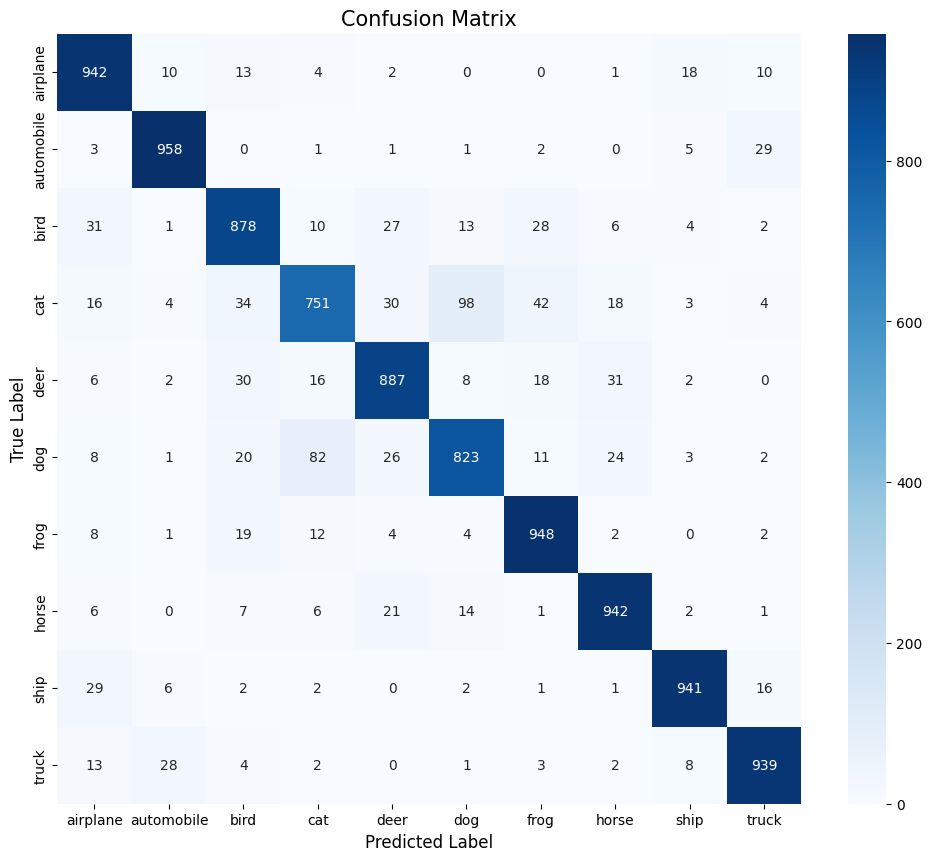

Confusion matrix plot saved to /content/drive/MyDrive/IISc_Submission/deit_trial_F1_1/evaluation_results/confusion_matrix.png


In [ ]:
# -- trying to test on 257/300 epoch model
print("\n--- Training complete. Starting final evaluation on test set. ---")
img_info = ImageParams(width=32, height=32, in_channel=3)
mparams =ModelParameters(patch_size=4, inner_dim=192, transformer_layers=12, num_head=3, embed_dropout=0.1, attn_dropout=0.0, mlp_dropout=0.1)
hparams = Hyperparameters(batch_size=1024, out_classes=10, epochs=300, learning_rate=5e-4*(1024/512), weight_decay=0.05)
data_handler = DataHandler(image_information=img_info, batch_size=hparams.batch_size)
train_loader, val_loader, test_loader = data_handler.get_dataloaders()
run_name = f'deit_trial_F1_1'
run_output_dir = f"/content/drive/MyDrive/IISc_Submission/{run_name}" # SAVING TO DRIVE
local_model_path = os.path.join(run_output_dir, "best_model.pth")
eval_results_dir = os.path.join(run_output_dir, "evaluation_results")
evaluator = Evaluator(
model=ViT(mparams=mparams, hparams=hparams, img_info=img_info),
test_loader=test_loader,
device='cpu',
output_dir=eval_results_dir)
final_metrics = evaluator.evaluate(model_path=local_model_path)

# Abalation Study: Effect of MixUp and CutMix
1. disabled `cutmix` and `mixup` and run the model for 30 epochs
1. did not disable `cutmix` and `mixup` and run the model for 30 epochs


--- Starting Run 1/1 (Seed: 300) ---
DataLoaders created successfully.
Training samples: 45000
Validation samples: 5000
Test samples: 10000
Starting Training...
--- Epoch 1/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 1 Summary:
  Train Loss: 2.1849 | Train Acc: 17.69%
  Val Loss:   1.9904 | Val Acc:   26.66%
  Current Learning Rate: 0.000069
✅ New best model saved with accuracy: 26.66%
--- Epoch 2/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 2 Summary:
  Train Loss: 2.0775 | Train Acc: 22.39%
  Val Loss:   1.9473 | Val Acc:   27.86%
  Current Learning Rate: 0.000153
✅ New best model saved with accuracy: 27.86%
--- Epoch 3/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 3 Summary:
  Train Loss: 1.9897 | Train Acc: 26.18%
  Val Loss:   1.7550 | Val Acc:   34.26%
  Current Learning Rate: 0.000281
✅ New best model saved with accuracy: 34.26%
--- Epoch 4/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Epoch 4 Summary:
  Train Loss: 1.8760 | Train Acc: 30.42%
  Val Loss:   1.6414 | Val Acc:   38.80%
  Current Learning Rate: 0.000438
✅ New best model saved with accuracy: 38.80%
--- Epoch 5/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Epoch 5 Summary:
  Train Loss: 1.7689 | Train Acc: 34.94%
  Val Loss:   1.5368 | Val Acc:   42.92%
  Current Learning Rate: 0.000605
✅ New best model saved with accuracy: 42.92%
--- Epoch 6/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Epoch 6 Summary:
  Train Loss: 1.6848 | Train Acc: 38.80%
  Val Loss:   1.4748 | Val Acc:   46.22%
  Current Learning Rate: 0.000762
✅ New best model saved with accuracy: 46.22%
--- Epoch 7/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Epoch 7 Summary:
  Train Loss: 1.5940 | Train Acc: 42.49%
  Val Loss:   1.3364 | Val Acc:   51.02%
  Current Learning Rate: 0.000890
✅ New best model saved with accuracy: 51.02%
--- Epoch 8/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch 8 Summary:
  Train Loss: 1.5414 | Train Acc: 44.34%
  Val Loss:   1.4154 | Val Acc:   47.58%
  Current Learning Rate: 0.000972
--- Epoch 9/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch 9 Summary:
  Train Loss: 1.4869 | Train Acc: 46.11%
  Val Loss:   1.2043 | Val Acc:   55.52%
  Current Learning Rate: 0.001000
✅ New best model saved with accuracy: 55.52%
--- Epoch 10/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Epoch 10 Summary:
  Train Loss: 1.4234 | Train Acc: 48.76%
  Val Loss:   1.1588 | Val Acc:   58.12%
  Current Learning Rate: 0.000994
✅ New best model saved with accuracy: 58.12%
--- Epoch 11/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Epoch 11 Summary:
  Train Loss: 1.3672 | Train Acc: 50.98%
  Val Loss:   1.1382 | Val Acc:   58.92%
  Current Learning Rate: 0.000977
✅ New best model saved with accuracy: 58.92%
--- Epoch 12/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Epoch 12 Summary:
  Train Loss: 1.3510 | Train Acc: 51.50%
  Val Loss:   1.1058 | Val Acc:   59.60%
  Current Learning Rate: 0.000950
✅ New best model saved with accuracy: 59.60%
--- Epoch 13/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


Epoch 13 Summary:
  Train Loss: 1.2837 | Train Acc: 54.23%
  Val Loss:   1.0333 | Val Acc:   62.88%
  Current Learning Rate: 0.000912
✅ New best model saved with accuracy: 62.88%
--- Epoch 14/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


Epoch 14 Summary:
  Train Loss: 1.2618 | Train Acc: 54.77%
  Val Loss:   1.0054 | Val Acc:   63.92%
  Current Learning Rate: 0.000865
✅ New best model saved with accuracy: 63.92%
--- Epoch 15/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Epoch 15 Summary:
  Train Loss: 1.2083 | Train Acc: 57.25%
  Val Loss:   0.9655 | Val Acc:   64.94%
  Current Learning Rate: 0.000810
✅ New best model saved with accuracy: 64.94%
--- Epoch 16/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch 16 Summary:
  Train Loss: 1.1763 | Train Acc: 57.97%
  Val Loss:   0.9665 | Val Acc:   64.82%
  Current Learning Rate: 0.000749
--- Epoch 17/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 17 Summary:
  Train Loss: 1.1425 | Train Acc: 59.37%
  Val Loss:   0.9390 | Val Acc:   66.18%
  Current Learning Rate: 0.000681
✅ New best model saved with accuracy: 66.18%
--- Epoch 18/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


Epoch 18 Summary:
  Train Loss: 1.1060 | Train Acc: 60.68%
  Val Loss:   0.8762 | Val Acc:   68.82%
  Current Learning Rate: 0.000610
✅ New best model saved with accuracy: 68.82%
--- Epoch 19/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


Epoch 19 Summary:
  Train Loss: 1.0751 | Train Acc: 61.80%
  Val Loss:   0.8894 | Val Acc:   68.42%
  Current Learning Rate: 0.000536
--- Epoch 20/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Epoch 20 Summary:
  Train Loss: 1.0495 | Train Acc: 63.00%
  Val Loss:   0.8709 | Val Acc:   69.36%
  Current Learning Rate: 0.000461
✅ New best model saved with accuracy: 69.36%
--- Epoch 21/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


Epoch 21 Summary:
  Train Loss: 1.0159 | Train Acc: 64.03%
  Val Loss:   0.8113 | Val Acc:   71.04%
  Current Learning Rate: 0.000387
✅ New best model saved with accuracy: 71.04%
--- Epoch 22/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 22 Summary:
  Train Loss: 0.9905 | Train Acc: 65.03%
  Val Loss:   0.7781 | Val Acc:   72.22%
  Current Learning Rate: 0.000316
✅ New best model saved with accuracy: 72.22%
--- Epoch 23/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch 23 Summary:
  Train Loss: 0.9616 | Train Acc: 66.13%
  Val Loss:   0.7931 | Val Acc:   71.82%
  Current Learning Rate: 0.000249
--- Epoch 24/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Epoch 24 Summary:
  Train Loss: 0.9451 | Train Acc: 66.58%
  Val Loss:   0.7732 | Val Acc:   72.56%
  Current Learning Rate: 0.000187
✅ New best model saved with accuracy: 72.56%
--- Epoch 25/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Epoch 25 Summary:
  Train Loss: 0.9184 | Train Acc: 67.64%
  Val Loss:   0.7606 | Val Acc:   73.68%
  Current Learning Rate: 0.000132
✅ New best model saved with accuracy: 73.68%
--- Epoch 26/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


Epoch 26 Summary:
  Train Loss: 0.8999 | Train Acc: 68.34%
  Val Loss:   0.7543 | Val Acc:   73.36%
  Current Learning Rate: 0.000086
--- Epoch 27/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Epoch 27 Summary:
  Train Loss: 0.8894 | Train Acc: 68.80%
  Val Loss:   0.7445 | Val Acc:   73.96%
  Current Learning Rate: 0.000049
✅ New best model saved with accuracy: 73.96%
--- Epoch 28/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch 28 Summary:
  Train Loss: 0.8743 | Train Acc: 69.25%
  Val Loss:   0.7351 | Val Acc:   73.88%
  Current Learning Rate: 0.000022
--- Epoch 29/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 29 Summary:
  Train Loss: 0.8700 | Train Acc: 69.23%
  Val Loss:   0.7350 | Val Acc:   74.04%
  Current Learning Rate: 0.000005
✅ New best model saved with accuracy: 74.04%
--- Epoch 30/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


Epoch 30 Summary:
  Train Loss: 0.8717 | Train Acc: 69.16%
  Val Loss:   0.7346 | Val Acc:   74.18%
  Current Learning Rate: 0.000000
✅ New best model saved with accuracy: 74.18%
--- Training Finished ---
Best Validation Accuracy: 74.18%
Training history saved to /content/drive/MyDrive/IISc_Submission/baseline_vit_abalation_F0_1/training_history.csv

--- Training complete. Starting final evaluation on test set. ---

--- Starting Final Evaluation ---


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]



Overall Test Accuracy: 73.29%

Classification Report:
                  precision  recall  f1-score     support  accuracy
airplane           0.726373  0.8070  0.764567   1000.0000    0.8070
automobile         0.804163  0.8500  0.826446   1000.0000    0.8500
bird               0.689977  0.5920  0.637244   1000.0000    0.5920
cat                0.658501  0.4570  0.539551   1000.0000    0.4570
deer               0.736471  0.6260  0.676757   1000.0000    0.6260
dog                0.599829  0.7030  0.647330   1000.0000    0.7030
frog               0.804975  0.8090  0.806983   1000.0000    0.8090
horse              0.688365  0.8460  0.759085   1000.0000    0.8460
ship               0.864017  0.8260  0.844581   1000.0000    0.8260
truck              0.761236  0.8130  0.786267   1000.0000    0.8130
accuracy           0.732900  0.7329  0.732900      0.7329    0.7329
macro avg          0.733391  0.7329  0.728881  10000.0000       NaN
weighted avg       0.733391  0.7329  0.728881  10000.0000    

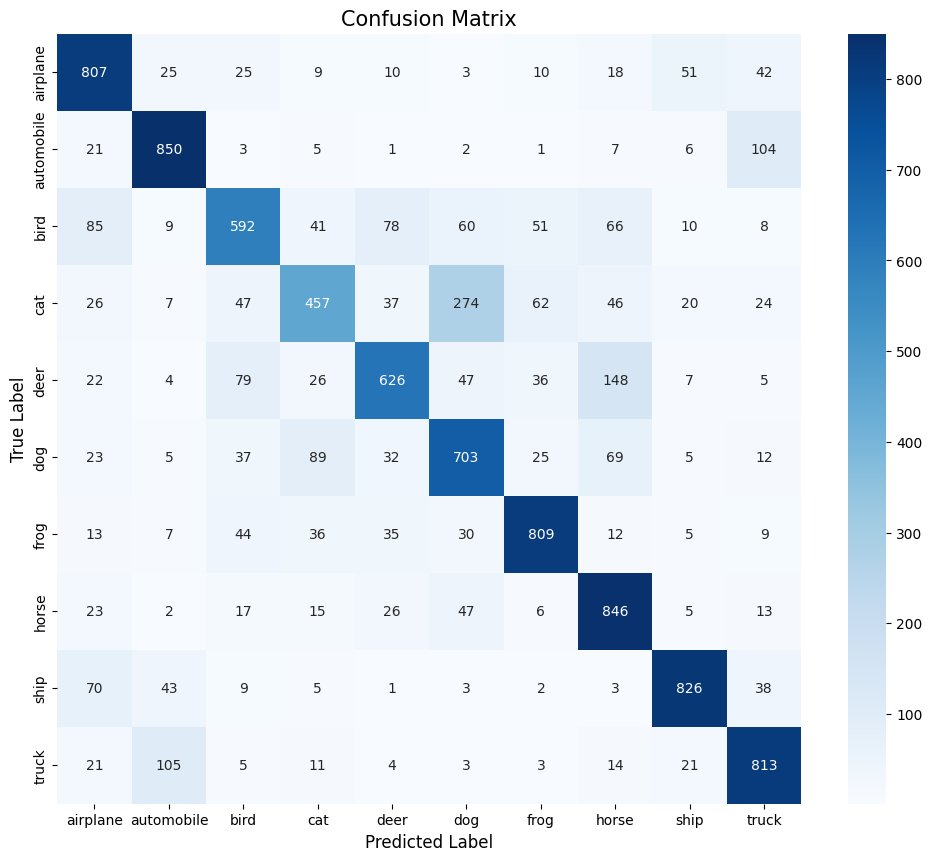

Confusion matrix plot saved to /content/drive/MyDrive/IISc_Submission/baseline_vit_abalation_F0_1/evaluation_results/confusion_matrix.png


In [ ]:
# --- baseline_vit_abalation ---
main(
    num_runs=1,
    master_seed=300,
    test_name=f'baseline_vit_abalation_F0',
    image_information=ImageParams(width=32, height=32, in_channel=3),
    model_parameters=ModelParameters(patch_size=4, inner_dim=192, transformer_layers=12, num_head=3, embed_dropout=0.1, attn_dropout=0.0, mlp_dropout=0.1),
    hyperparameters=Hyperparameters(batch_size=1024, out_classes=10, epochs=30, learning_rate=5e-4*(1024/512), weight_decay=0.05)
)


--- Starting Run 1/1 (Seed: 350) ---
DataLoaders created successfully.
Training samples: 45000
Validation samples: 5000
Test samples: 10000
Starting Training...
--- Epoch 1/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Epoch 1 Summary:
  Train Loss: 2.2680 | Train Acc: 15.41%
  Val Loss:   2.0686 | Val Acc:   20.28%
  Current Learning Rate: 0.000069
✅ New best model saved with accuracy: 20.28%
--- Epoch 2/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Epoch 2 Summary:
  Train Loss: 2.2023 | Train Acc: 18.57%
  Val Loss:   1.9774 | Val Acc:   27.00%
  Current Learning Rate: 0.000153
✅ New best model saved with accuracy: 27.00%
--- Epoch 3/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Epoch 3 Summary:
  Train Loss: 2.1704 | Train Acc: 20.66%
  Val Loss:   1.9462 | Val Acc:   26.04%
  Current Learning Rate: 0.000281
--- Epoch 4/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Epoch 4 Summary:
  Train Loss: 2.1835 | Train Acc: 20.33%
  Val Loss:   1.8943 | Val Acc:   30.42%
  Current Learning Rate: 0.000438
✅ New best model saved with accuracy: 30.42%
--- Epoch 5/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


Epoch 5 Summary:
  Train Loss: 2.1172 | Train Acc: 24.40%
  Val Loss:   1.7482 | Val Acc:   36.48%
  Current Learning Rate: 0.000605
✅ New best model saved with accuracy: 36.48%
--- Epoch 6/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


Epoch 6 Summary:
  Train Loss: 2.0986 | Train Acc: 25.72%
  Val Loss:   1.7270 | Val Acc:   39.66%
  Current Learning Rate: 0.000762
✅ New best model saved with accuracy: 39.66%
--- Epoch 7/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


Epoch 7 Summary:
  Train Loss: 2.0671 | Train Acc: 27.52%
  Val Loss:   1.6335 | Val Acc:   43.08%
  Current Learning Rate: 0.000890
✅ New best model saved with accuracy: 43.08%
--- Epoch 8/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Epoch 8 Summary:
  Train Loss: 2.0596 | Train Acc: 28.00%
  Val Loss:   1.6190 | Val Acc:   43.34%
  Current Learning Rate: 0.000972
✅ New best model saved with accuracy: 43.34%
--- Epoch 9/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Epoch 9 Summary:
  Train Loss: 1.9822 | Train Acc: 32.12%
  Val Loss:   1.4970 | Val Acc:   46.12%
  Current Learning Rate: 0.001000
✅ New best model saved with accuracy: 46.12%
--- Epoch 10/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Epoch 10 Summary:
  Train Loss: 1.9734 | Train Acc: 33.72%
  Val Loss:   1.4167 | Val Acc:   50.12%
  Current Learning Rate: 0.000994
✅ New best model saved with accuracy: 50.12%
--- Epoch 11/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Epoch 11 Summary:
  Train Loss: 1.9519 | Train Acc: 34.58%
  Val Loss:   1.5360 | Val Acc:   45.70%
  Current Learning Rate: 0.000977
--- Epoch 12/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Epoch 12 Summary:
  Train Loss: 1.9546 | Train Acc: 34.07%
  Val Loss:   1.4603 | Val Acc:   46.82%
  Current Learning Rate: 0.000950
--- Epoch 13/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Epoch 13 Summary:
  Train Loss: 1.9542 | Train Acc: 33.86%
  Val Loss:   1.4259 | Val Acc:   50.50%
  Current Learning Rate: 0.000912
✅ New best model saved with accuracy: 50.50%
--- Epoch 14/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


Epoch 14 Summary:
  Train Loss: 1.9542 | Train Acc: 34.45%
  Val Loss:   1.3879 | Val Acc:   50.74%
  Current Learning Rate: 0.000865
✅ New best model saved with accuracy: 50.74%
--- Epoch 15/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Epoch 15 Summary:
  Train Loss: 1.8539 | Train Acc: 38.26%
  Val Loss:   1.3419 | Val Acc:   51.10%
  Current Learning Rate: 0.000810
✅ New best model saved with accuracy: 51.10%
--- Epoch 16/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Epoch 16 Summary:
  Train Loss: 1.8540 | Train Acc: 39.63%
  Val Loss:   1.3277 | Val Acc:   54.22%
  Current Learning Rate: 0.000749
✅ New best model saved with accuracy: 54.22%
--- Epoch 17/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 17 Summary:
  Train Loss: 1.8564 | Train Acc: 39.26%
  Val Loss:   1.3040 | Val Acc:   55.04%
  Current Learning Rate: 0.000681
✅ New best model saved with accuracy: 55.04%
--- Epoch 18/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Epoch 18 Summary:
  Train Loss: 1.8720 | Train Acc: 38.86%
  Val Loss:   1.2515 | Val Acc:   56.54%
  Current Learning Rate: 0.000610
✅ New best model saved with accuracy: 56.54%
--- Epoch 19/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


Epoch 19 Summary:
  Train Loss: 1.8172 | Train Acc: 41.20%
  Val Loss:   1.2474 | Val Acc:   57.16%
  Current Learning Rate: 0.000536
✅ New best model saved with accuracy: 57.16%
--- Epoch 20/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Epoch 20 Summary:
  Train Loss: 1.8216 | Train Acc: 41.97%
  Val Loss:   1.2879 | Val Acc:   56.32%
  Current Learning Rate: 0.000461
--- Epoch 21/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


Epoch 21 Summary:
  Train Loss: 1.8028 | Train Acc: 42.29%
  Val Loss:   1.2078 | Val Acc:   59.16%
  Current Learning Rate: 0.000387
✅ New best model saved with accuracy: 59.16%
--- Epoch 22/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


Epoch 22 Summary:
  Train Loss: 1.8498 | Train Acc: 41.06%
  Val Loss:   1.2073 | Val Acc:   59.12%
  Current Learning Rate: 0.000316
--- Epoch 23/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch 23 Summary:
  Train Loss: 1.8199 | Train Acc: 41.52%
  Val Loss:   1.1835 | Val Acc:   60.74%
  Current Learning Rate: 0.000249
✅ New best model saved with accuracy: 60.74%
--- Epoch 24/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Epoch 24 Summary:
  Train Loss: 1.7784 | Train Acc: 43.98%
  Val Loss:   1.1042 | Val Acc:   62.10%
  Current Learning Rate: 0.000187
✅ New best model saved with accuracy: 62.10%
--- Epoch 25/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Epoch 25 Summary:
  Train Loss: 1.7558 | Train Acc: 45.90%
  Val Loss:   1.1239 | Val Acc:   61.76%
  Current Learning Rate: 0.000132
--- Epoch 26/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


Epoch 26 Summary:
  Train Loss: 1.7621 | Train Acc: 44.54%
  Val Loss:   1.0924 | Val Acc:   63.18%
  Current Learning Rate: 0.000086
✅ New best model saved with accuracy: 63.18%
--- Epoch 27/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Epoch 27 Summary:
  Train Loss: 1.7320 | Train Acc: 44.96%
  Val Loss:   1.0871 | Val Acc:   63.14%
  Current Learning Rate: 0.000049
--- Epoch 28/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 28 Summary:
  Train Loss: 1.7343 | Train Acc: 46.16%
  Val Loss:   1.0865 | Val Acc:   62.88%
  Current Learning Rate: 0.000022
--- Epoch 29/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


Epoch 29 Summary:
  Train Loss: 1.7727 | Train Acc: 43.68%
  Val Loss:   1.0752 | Val Acc:   63.74%
  Current Learning Rate: 0.000005
✅ New best model saved with accuracy: 63.74%
--- Epoch 30/30 ---


Validating: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


Epoch 30 Summary:
  Train Loss: 1.7393 | Train Acc: 45.69%
  Val Loss:   1.0764 | Val Acc:   63.52%
  Current Learning Rate: 0.000000
--- Training Finished ---
Best Validation Accuracy: 63.74%
Training history saved to /content/drive/MyDrive/IISc_Submission/mixupcutmix_testing_F0_1/training_history.csv

--- Training complete. Starting final evaluation on test set. ---

--- Starting Final Evaluation ---


Testing: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]



Overall Test Accuracy: 63.61%

Classification Report:
                  precision  recall  f1-score     support  accuracy
airplane           0.576426  0.7580  0.654860   1000.0000    0.7580
automobile         0.696157  0.7790  0.735252   1000.0000    0.7790
bird               0.540598  0.5060  0.522727   1000.0000    0.5060
cat                0.573770  0.3150  0.406714   1000.0000    0.3150
deer               0.647541  0.4740  0.547344   1000.0000    0.4740
dog                0.558994  0.5780  0.568338   1000.0000    0.5780
frog               0.620690  0.8100  0.702820   1000.0000    0.8100
horse              0.650264  0.7400  0.692236   1000.0000    0.7400
ship               0.747115  0.7770  0.761765   1000.0000    0.7770
truck              0.750000  0.6240  0.681223   1000.0000    0.6240
accuracy           0.636100  0.6361  0.636100      0.6361    0.6361
macro avg          0.636156  0.6361  0.627328  10000.0000       NaN
weighted avg       0.636156  0.6361  0.627328  10000.0000    

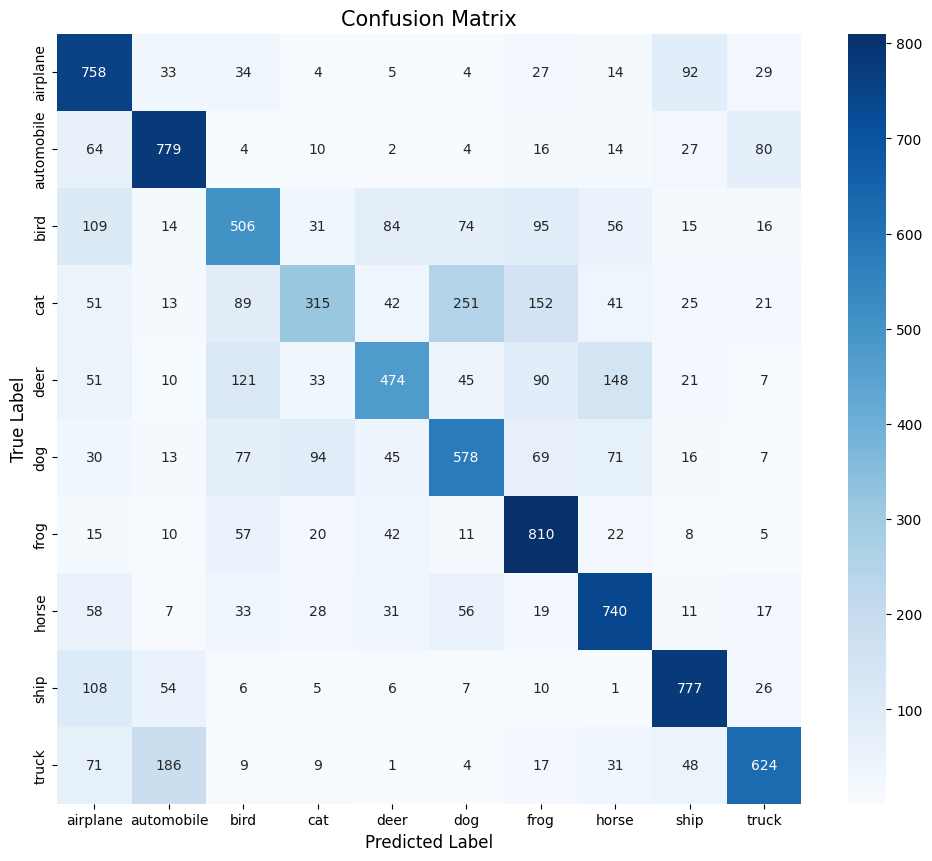

Confusion matrix plot saved to /content/drive/MyDrive/IISc_Submission/mixupcutmix_testing_F0_1/evaluation_results/confusion_matrix.png


In [ ]:
# --- mixupcutmix_vit_abalation  ---
main(
    num_runs=1,
    master_seed=350,
    test_name=f'mixupcutmix_testing_F0',
    image_information=ImageParams(width=32, height=32, in_channel=3),
    model_parameters=ModelParameters(patch_size=4, inner_dim=192, transformer_layers=12, num_head=3, embed_dropout=0.1, attn_dropout=0.0, mlp_dropout=0.1),
    hyperparameters=Hyperparameters(batch_size=1024, out_classes=10, epochs=30, learning_rate=5e-4*(1024/512), weight_decay=0.05)
)

# Evaluate Best Trained ViT Model

This cell runs the **final evaluation** on the CIFAR-10 test set using the best pre-trained model.

> **Note:** Make sure you have:  
> 1. Uploaded the pretrained model folder from [GitHub/Drive](https://github.com/Aleptonic/IISC-VIT/edit/main/README.md)  
> 2. Mounted your Google Drive in Colab (`from google.colab import drive; drive.mount('/content/drive')`)  



In [ ]:
# --- Imports ---
import os
import pandas as pd

# --- Setup ---
print("\n--- Starting final evaluation on the test set ---")

# Image and model parameters
img_info = ImageParams(width=32, height=32, in_channel=3)
mparams = ModelParameters(
    patch_size=4,
    inner_dim=192,
    transformer_layers=12,
    num_head=3,
    embed_dropout=0.1,
    attn_dropout=0.0,
    mlp_dropout=0.1
)
hparams = Hyperparameters(
    batch_size=1024,
    out_classes=10,
    epochs=300,
    learning_rate=5e-4 * (1024/512),
    weight_decay=0.05
)

# --- Data Loading ---
data_handler = DataHandler(image_information=img_info, batch_size=hparams.batch_size)
train_loader, val_loader, test_loader = data_handler.get_dataloaders()

# --- Paths ---
run_name = 'deit_trial_F1_1'
run_output_dir = f"/content/drive/MyDrive/IISc_Submission/{run_name}"  # Folder in mounted Drive
local_model_path = os.path.join(run_output_dir, "best_model.pth")
eval_results_dir = os.path.join(run_output_dir, "evaluation_results")

# --- Evaluation ---
evaluator = Evaluator(
    model=ViT(mparams=mparams, hparams=hparams, img_info=img_info),
    test_loader=test_loader,
    device='cpu',  # Switch to 'cuda' if GPU available and limits allow
    output_dir=eval_results_dir
)

# Run evaluation
final_metrics = evaluator.evaluate(model_path=local_model_path)
